In [1]:
import music21 as ms
import numpy as np

In [65]:
def tokenize(score) -> str:
    output = ['xxbos']
    last_offset = 0
    last_duration = 0
    
    # in order to get duration for xxsep token, we need to get offset between currently played note and prev
    for element in score.recurse().stream().notesAndRests:
        if isinstance(element, (note.Note, chord.Chord, note.Rest)):
            if element.offset != last_offset:
                output.append(f'xxsep d{float(element.offset - last_offset)}')
                
            if isinstance(element, chord.Chord):
                # For chords, handle each note in the chord
                for n in element.notes:
                    midi_pitch = n.pitch.midi
                    try:
                        dur = float(n.duration.quarterLength)
                    except:
                        # This means it returned a fraction, which we need to handle
                        frac = n.duration.quarterLength.split('/')
                        dur = float(frac[0]/frac[1])
                    output.append(f'n{midi_pitch} d{dur}')
                    
            elif isinstance(element, note.Note):
                midi_pitch = element.pitch.midi
                try:
                    dur = float(element.duration.quarterLength)
                except:
                    frac = element.duration.quarterLength.split('/')
                    dur = float(frac[0]/frac[1])
                output.append(f'n{midi_pitch} d{dur}')
            else:
                # For rests, just update the duration
                try:
                    dur = float(element.duration.quarterLength)
                except:
                    frac = element.duration.quarterLength.split('/')
                    dur = float(frac[0]/frac[1])
                output.append(f'n0 d{dur}')
                
            # Update the last note's offset and duration
            # Need to make sure they are floats
            last_offset = float(element.offset)
            last_duration = float(dur)
    
    output.append('xxeos')
    # Join the sequence into a single string
    output_text = ' '.join(output)

    return output_text

In [66]:
from music21 import stream, note, chord, duration

def musicify(tokens):
    s = ms.stream.Stream()
    # If notes contain same duration between xxsep tokens, play as a chord
    note_group = []
    
    total_offset = 0.0
    
    for i in range(1, len(tokens), 2):
        # End loop if xxeos token occurs
        if tokens[i] == 'xxeos':
            break
        if tokens[i] == 'xxsep':
            offset_token = tokens[i+1]
            offset = float(offset_token[1:])
            
            total_offset += offset # Add offset to total, so now we insert notes at this offset
            continue
        
        pitch_token = tokens[i]
        dur_token = tokens[i+1]
        pitch = int(pitch_token[1:])
        dur = float(dur_token[1:])

        if pitch == 0:
            new_rest = ms.note.Rest()
            new_rest.duration.quarterLength = dur
            continue
            
        new_note = ms.note.Note(pitch)
        new_note.duration.quarterLength = dur
        s.insert(total_offset, new_note)
        


    return s

In [67]:
score = ms.converter.parse('bach.mid')
tokens = tokenize(score).split()

In [68]:
for i in range(1, len(tokens)):
    if '/' in tokens[i]:
        print(tokens[i-1])
        print(tokens[i])

In [69]:
stream = musicify(tokens)

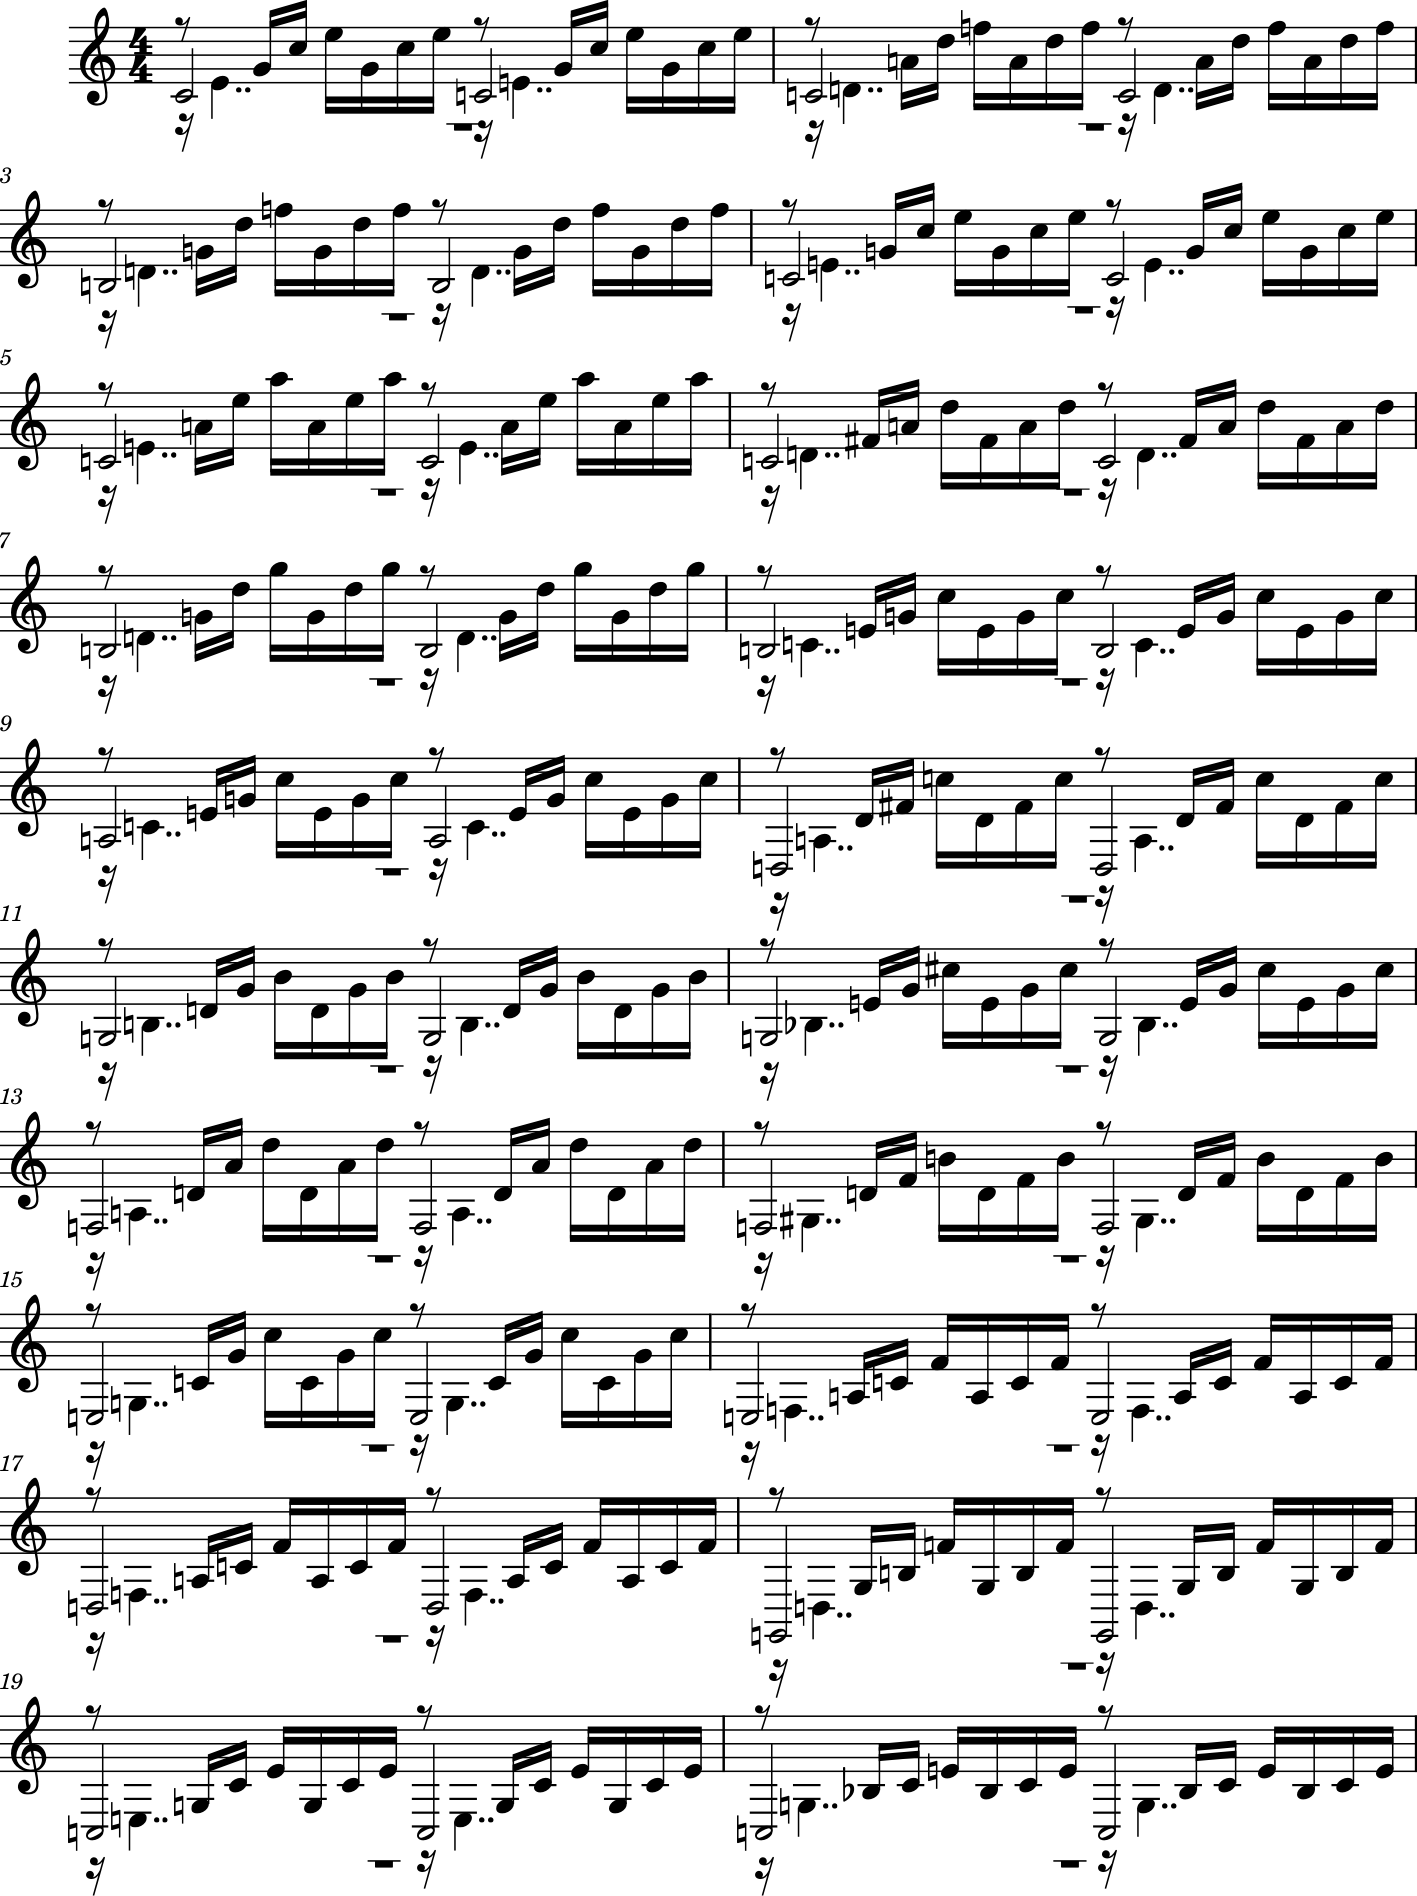

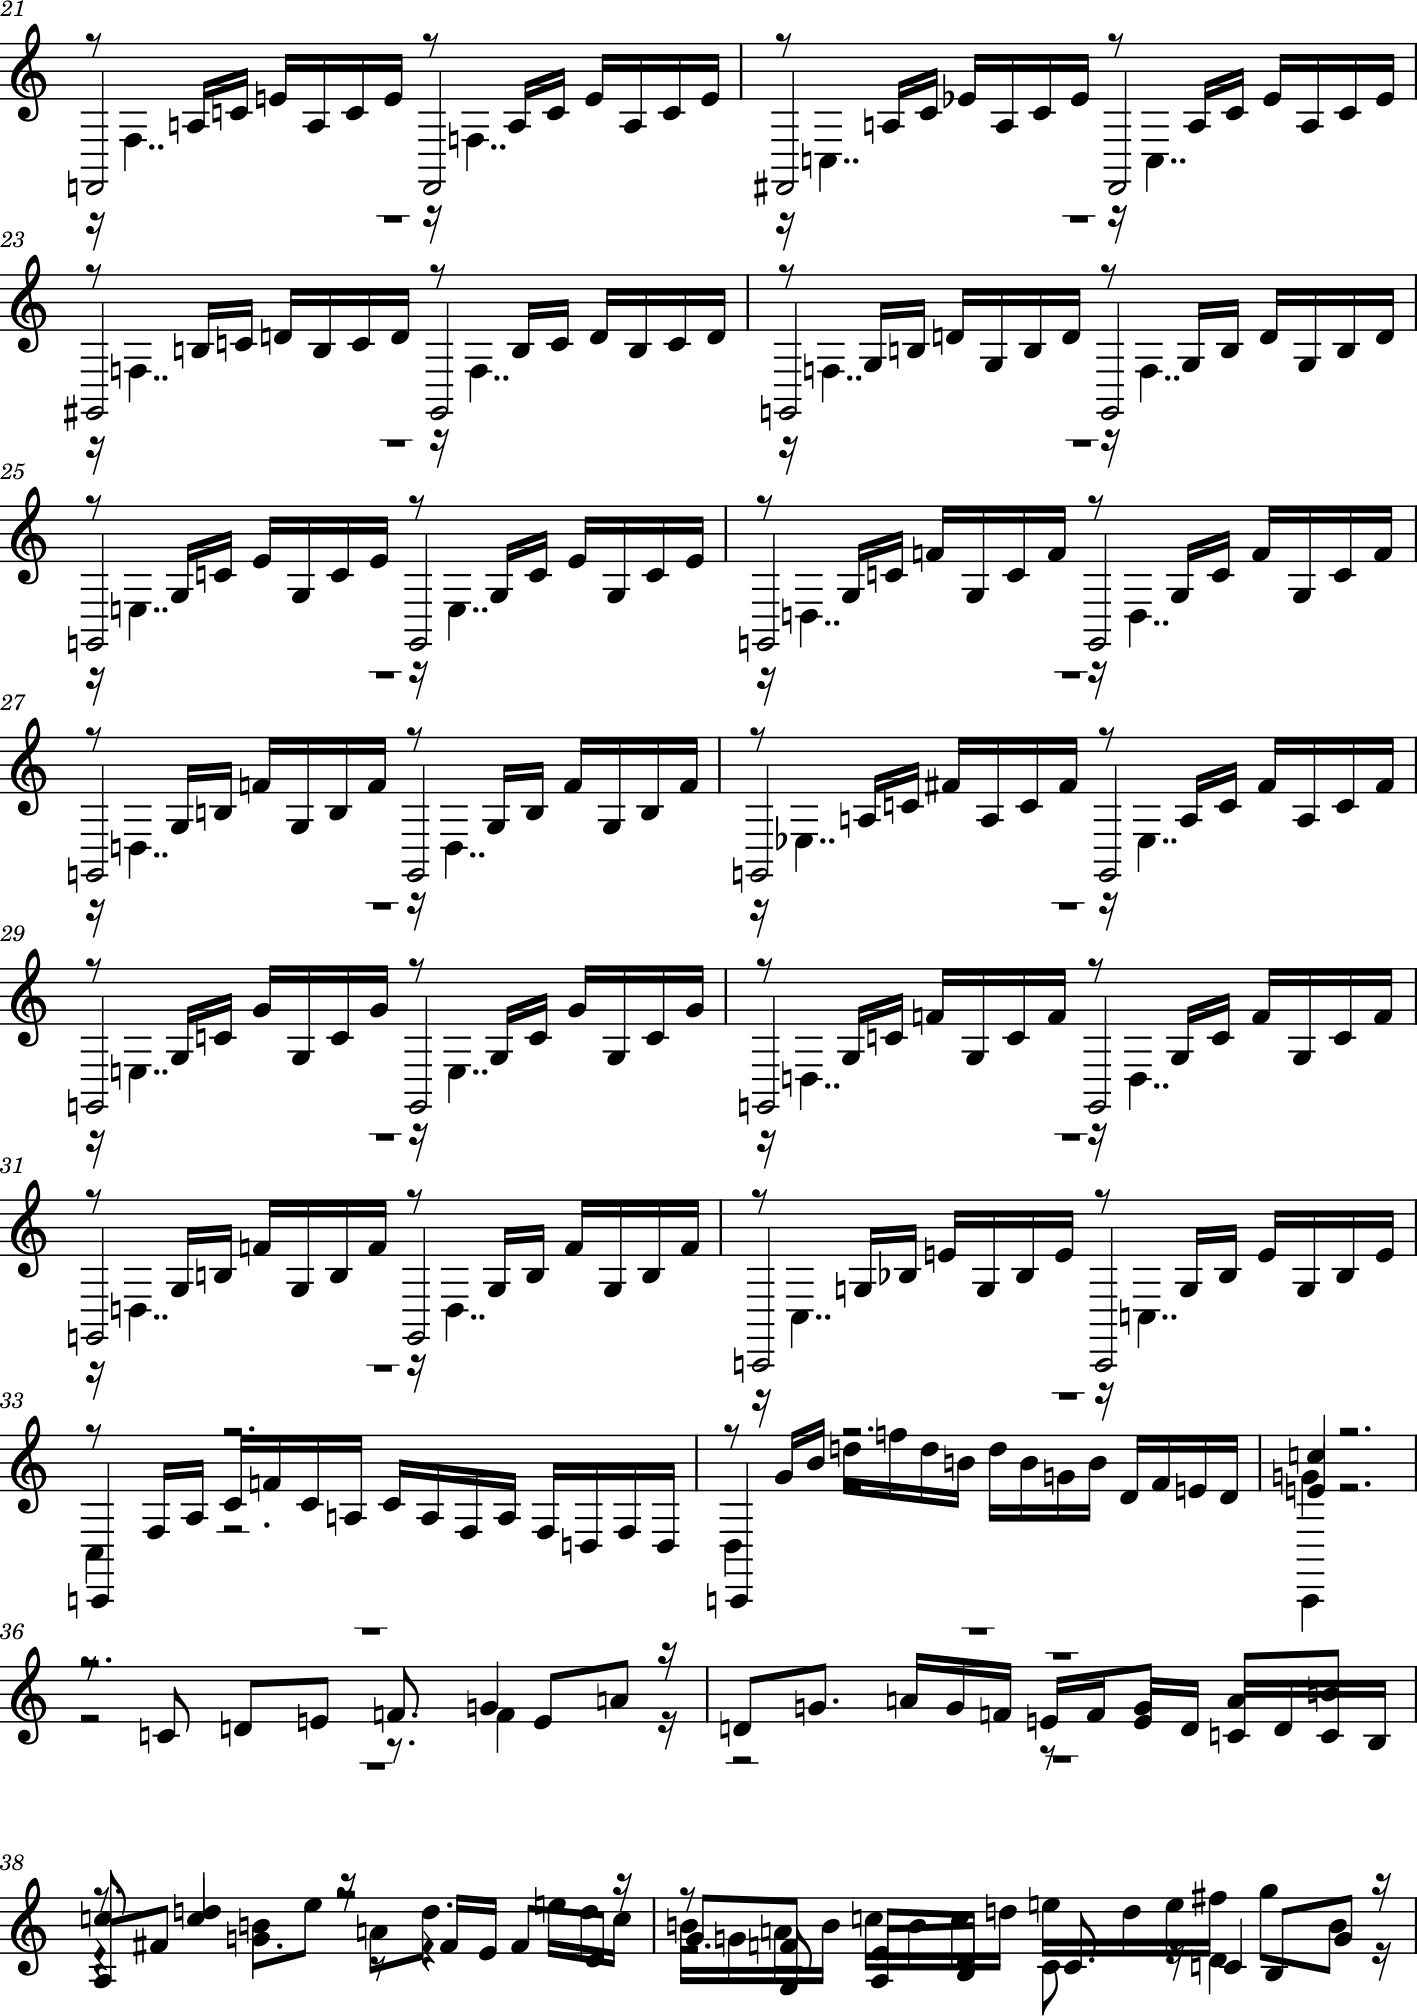

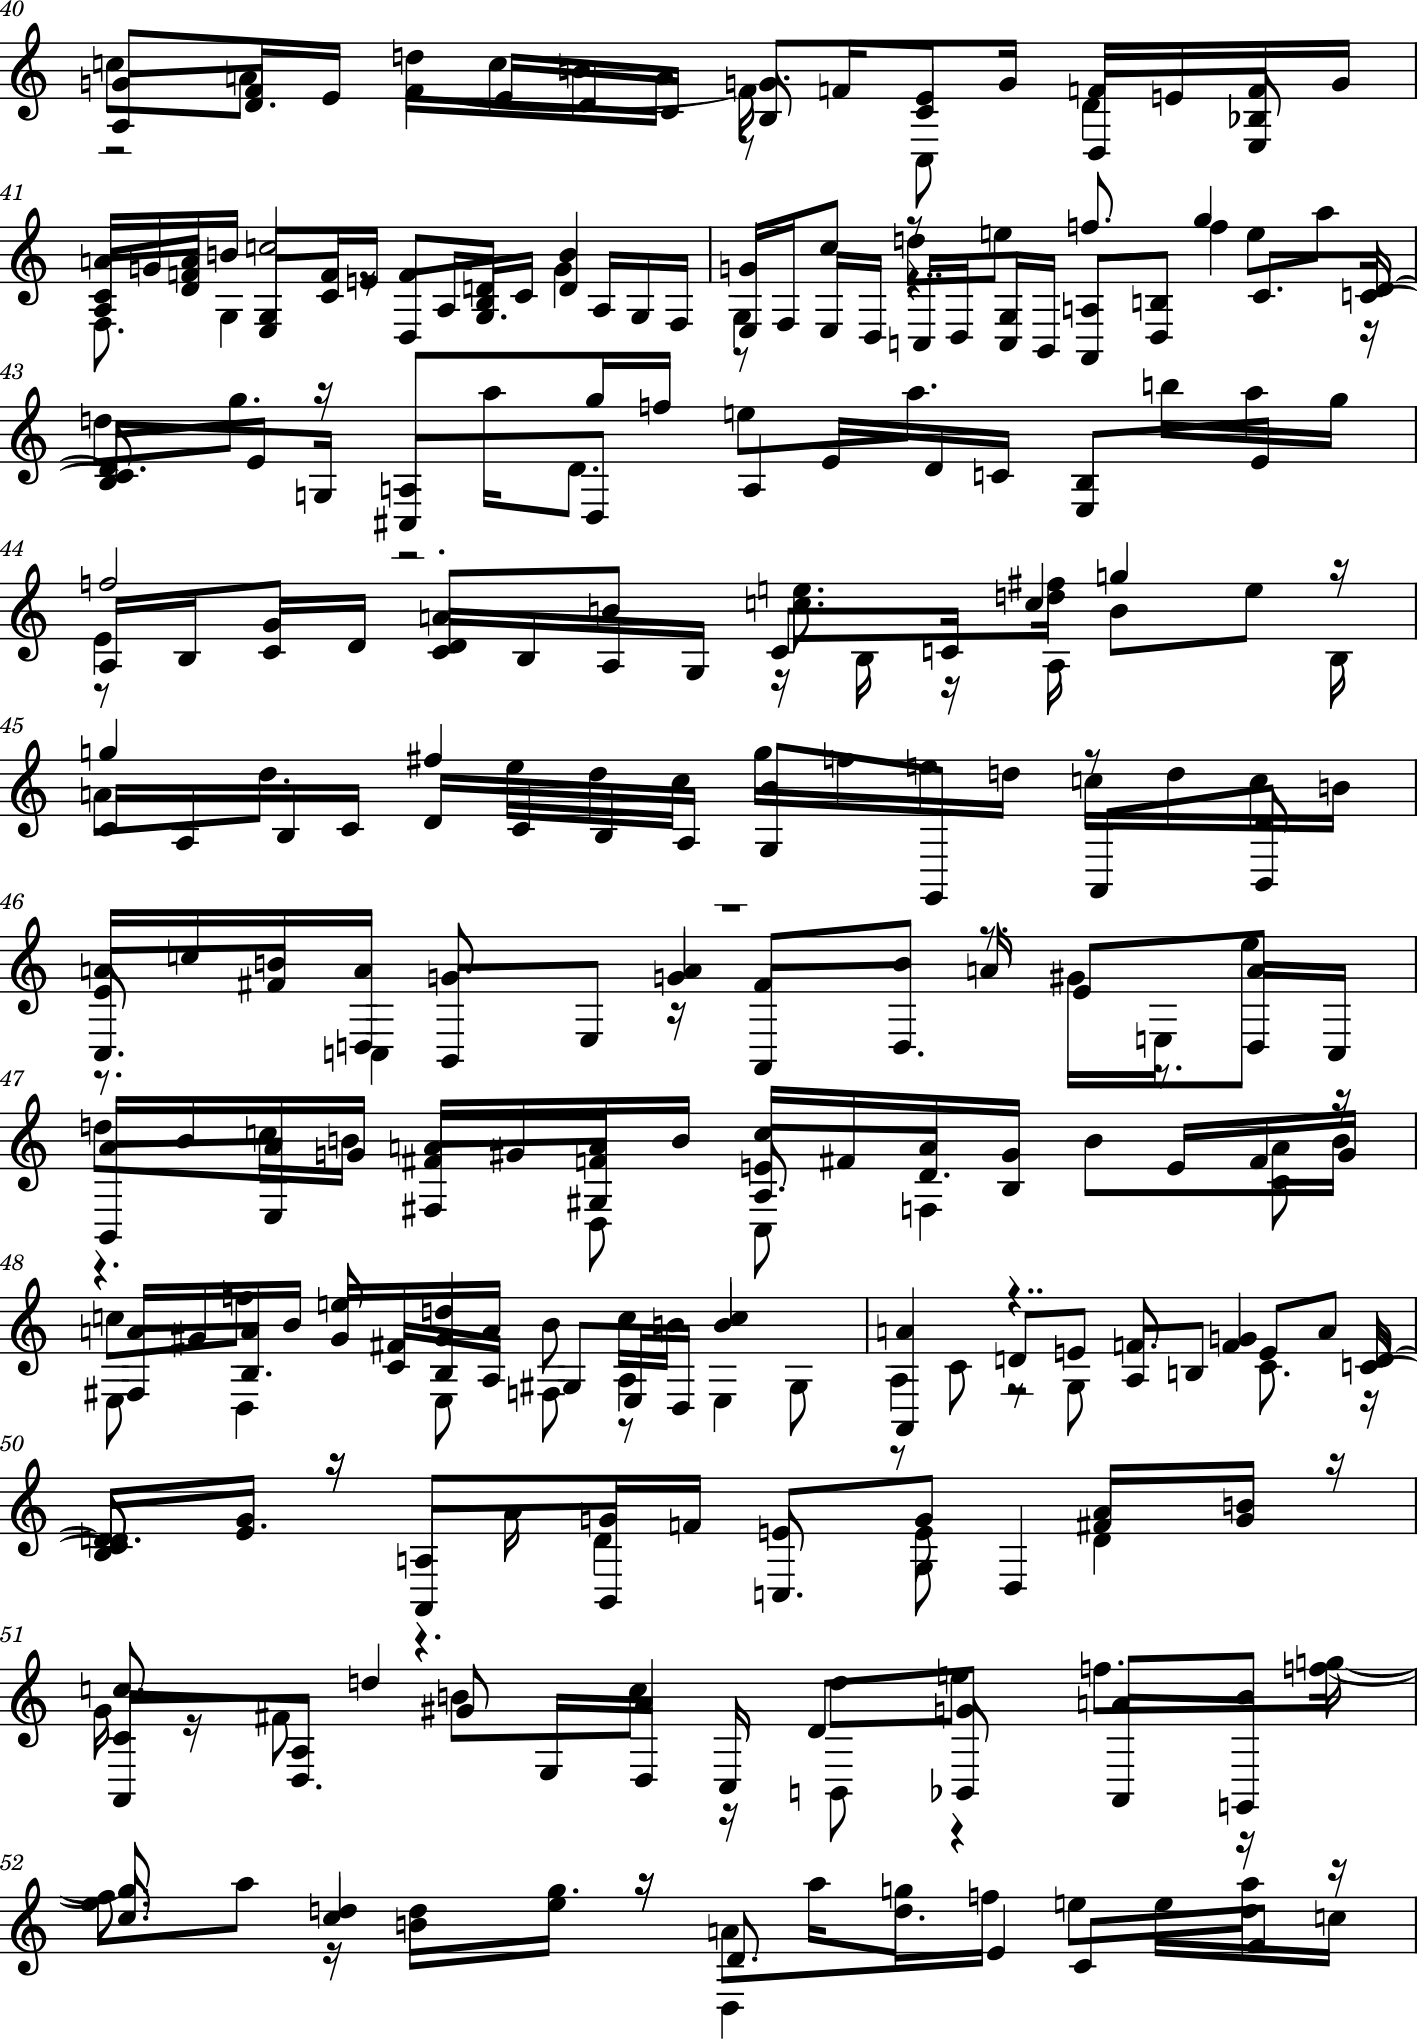

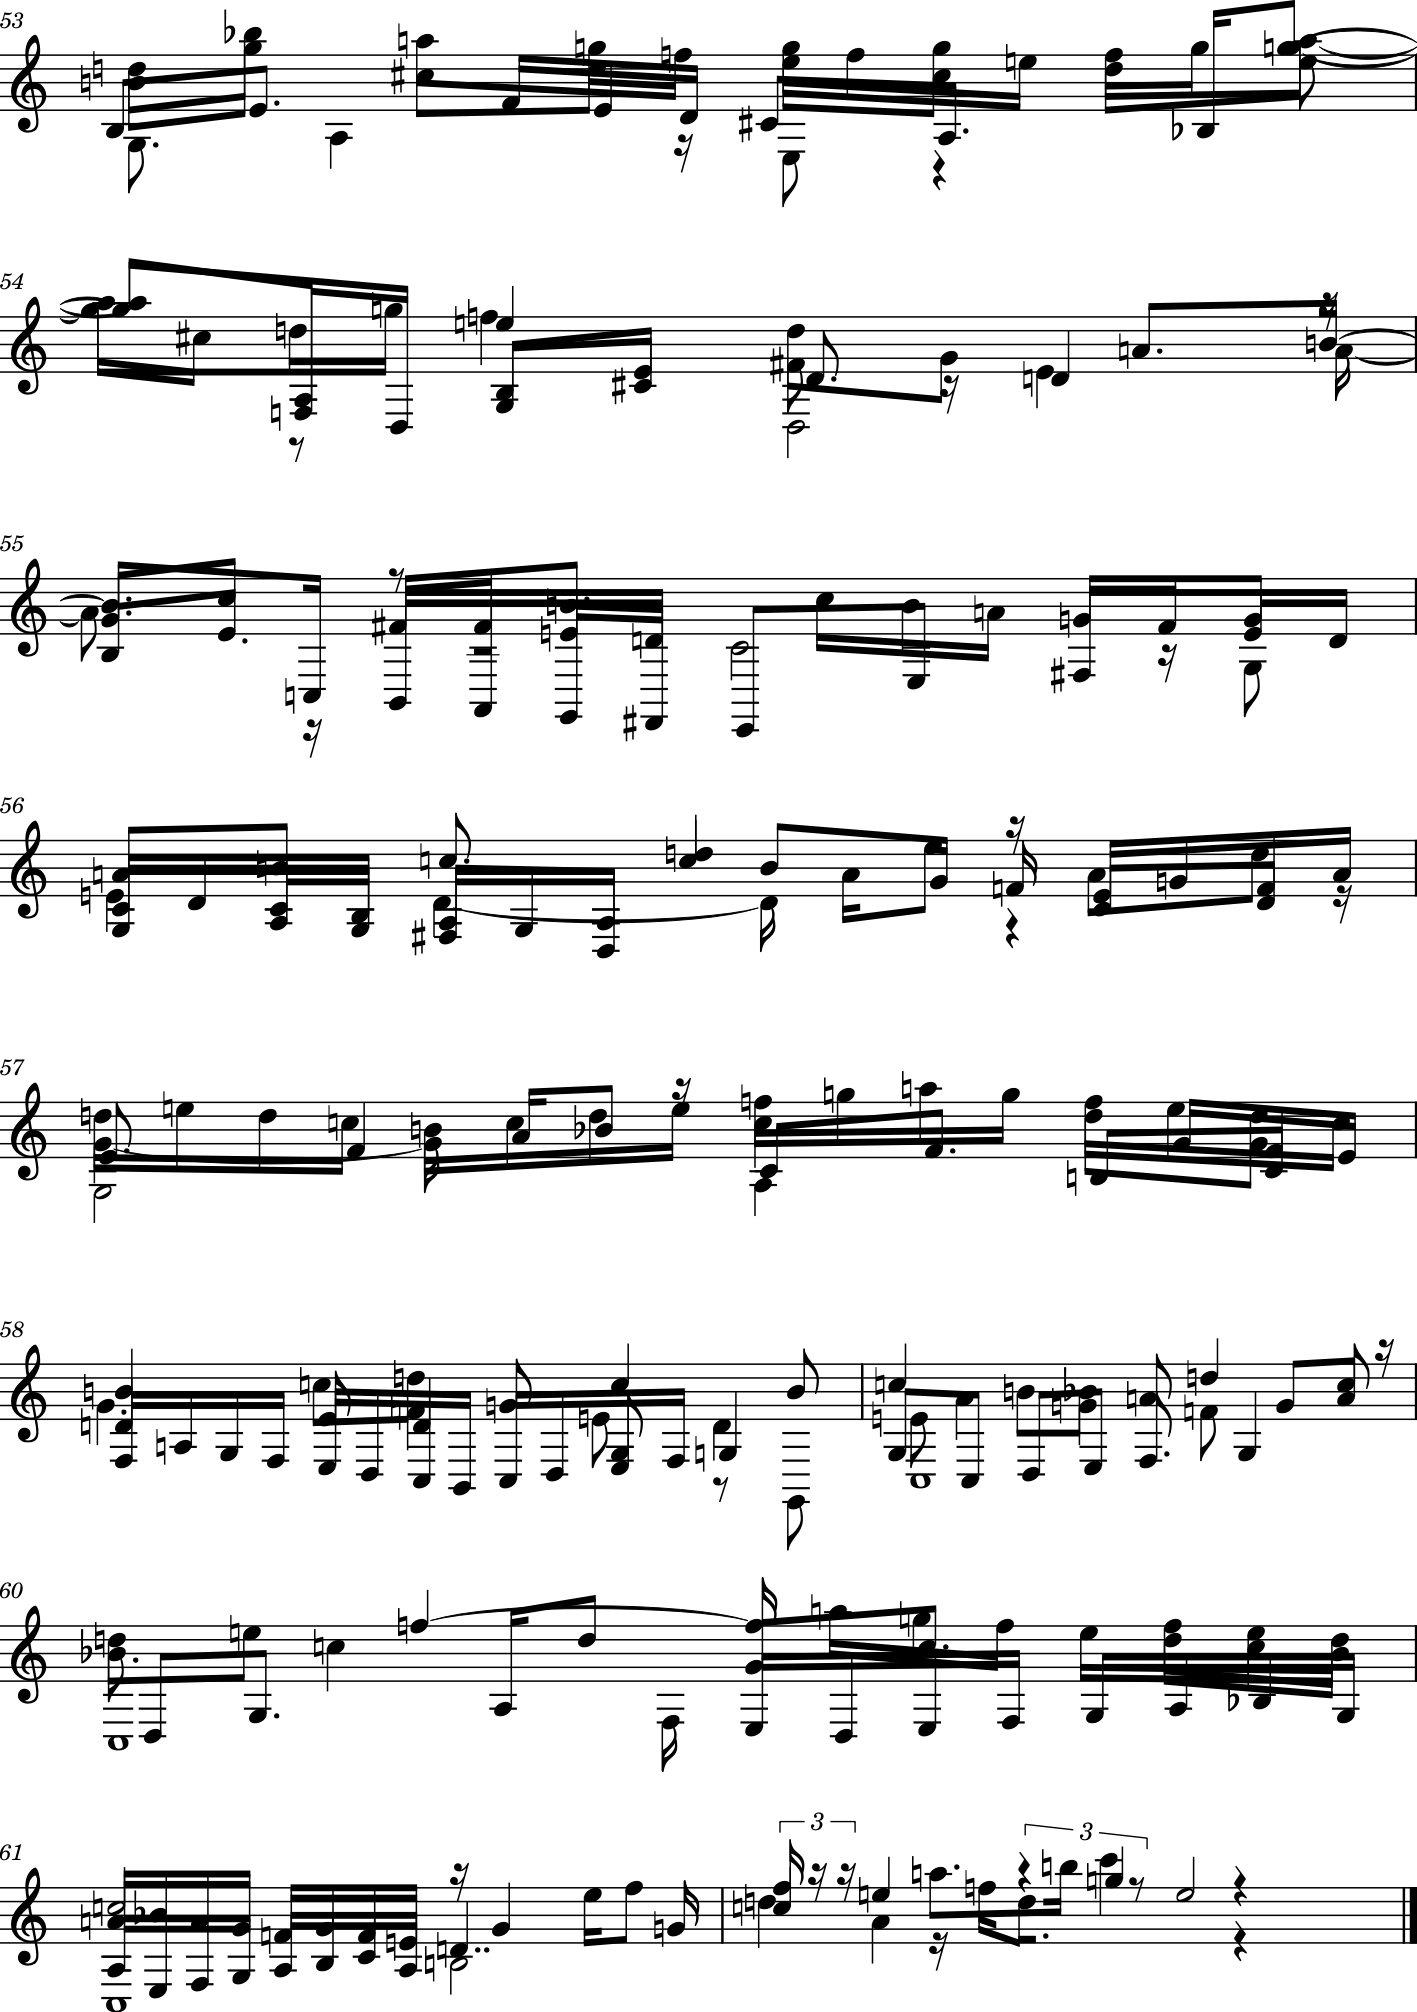

In [70]:
stream.show()

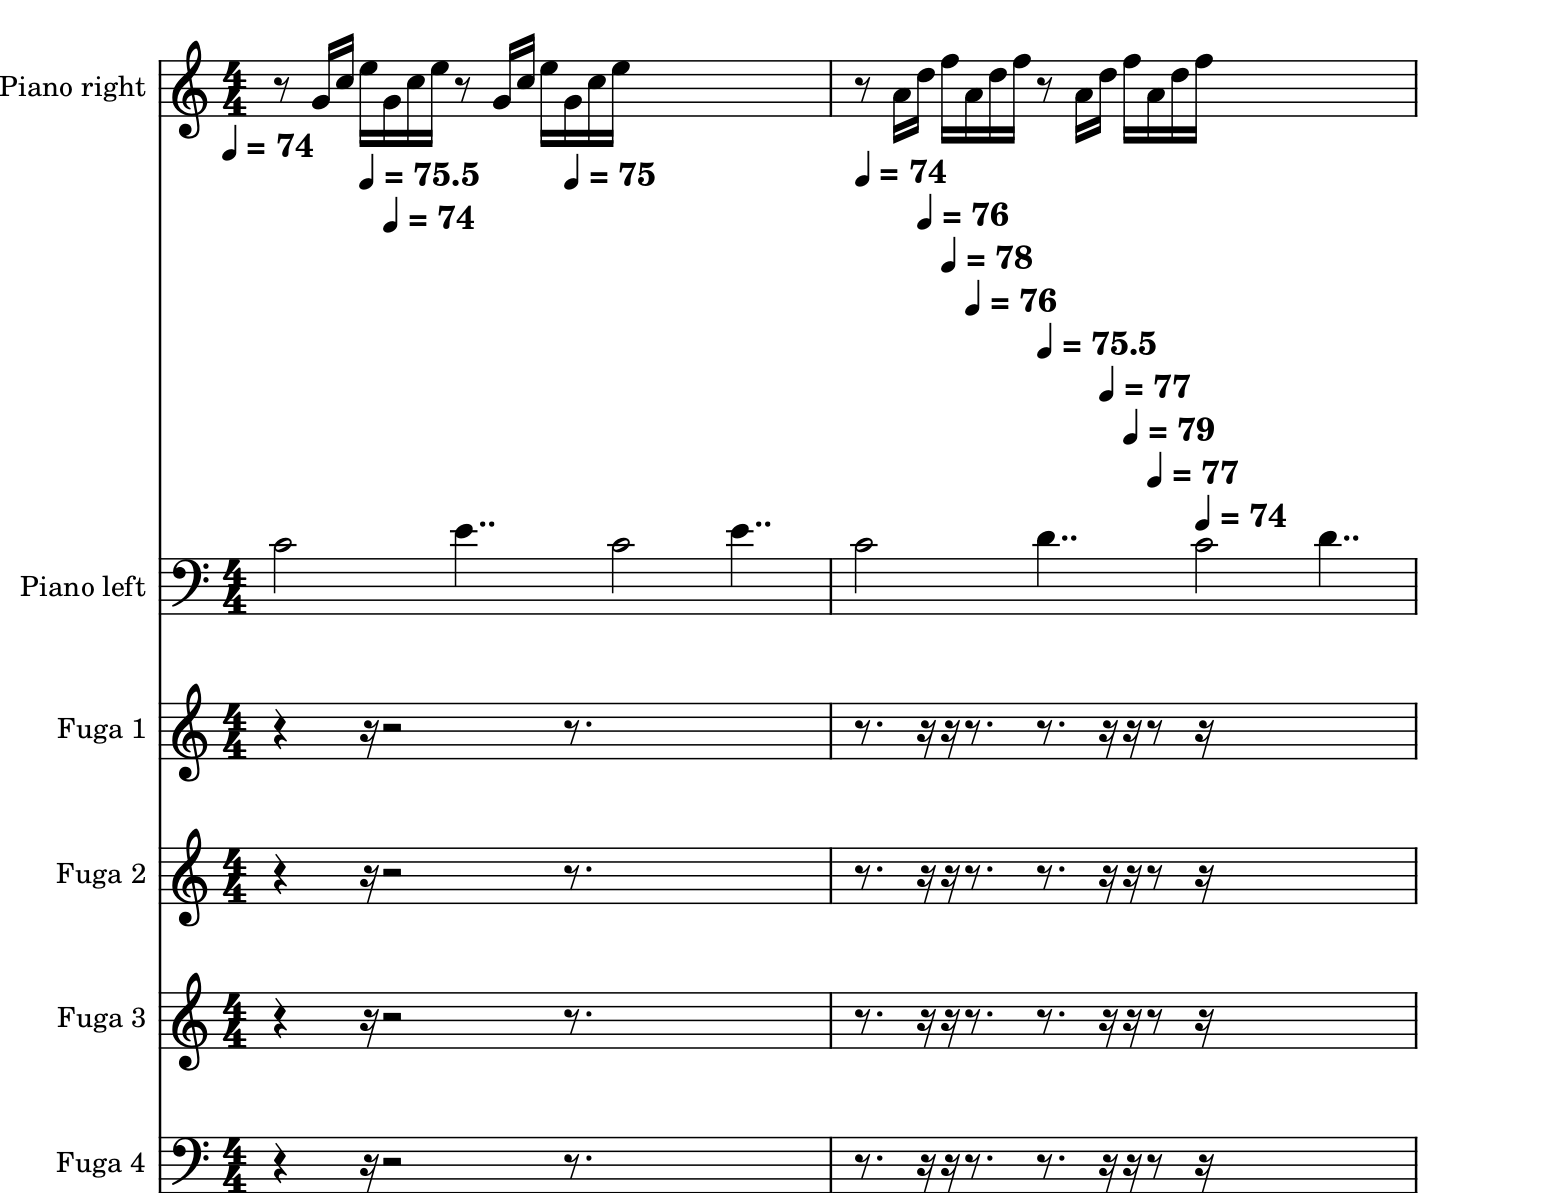

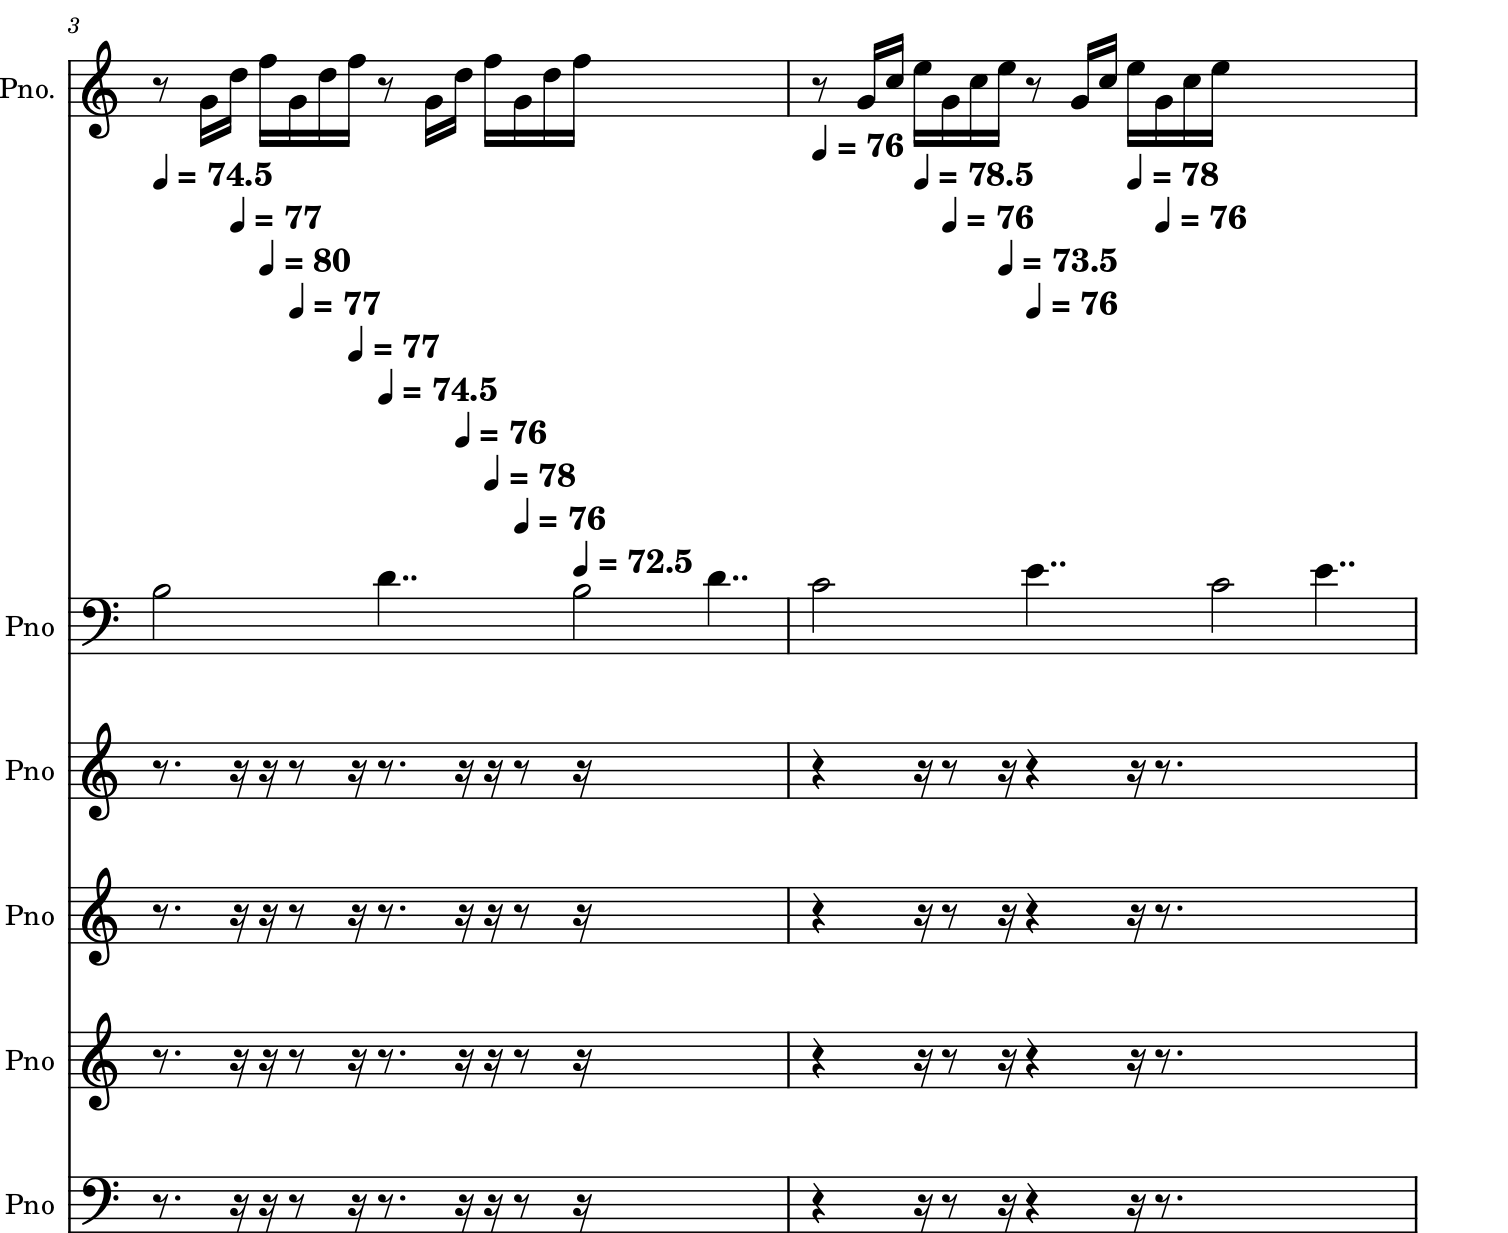

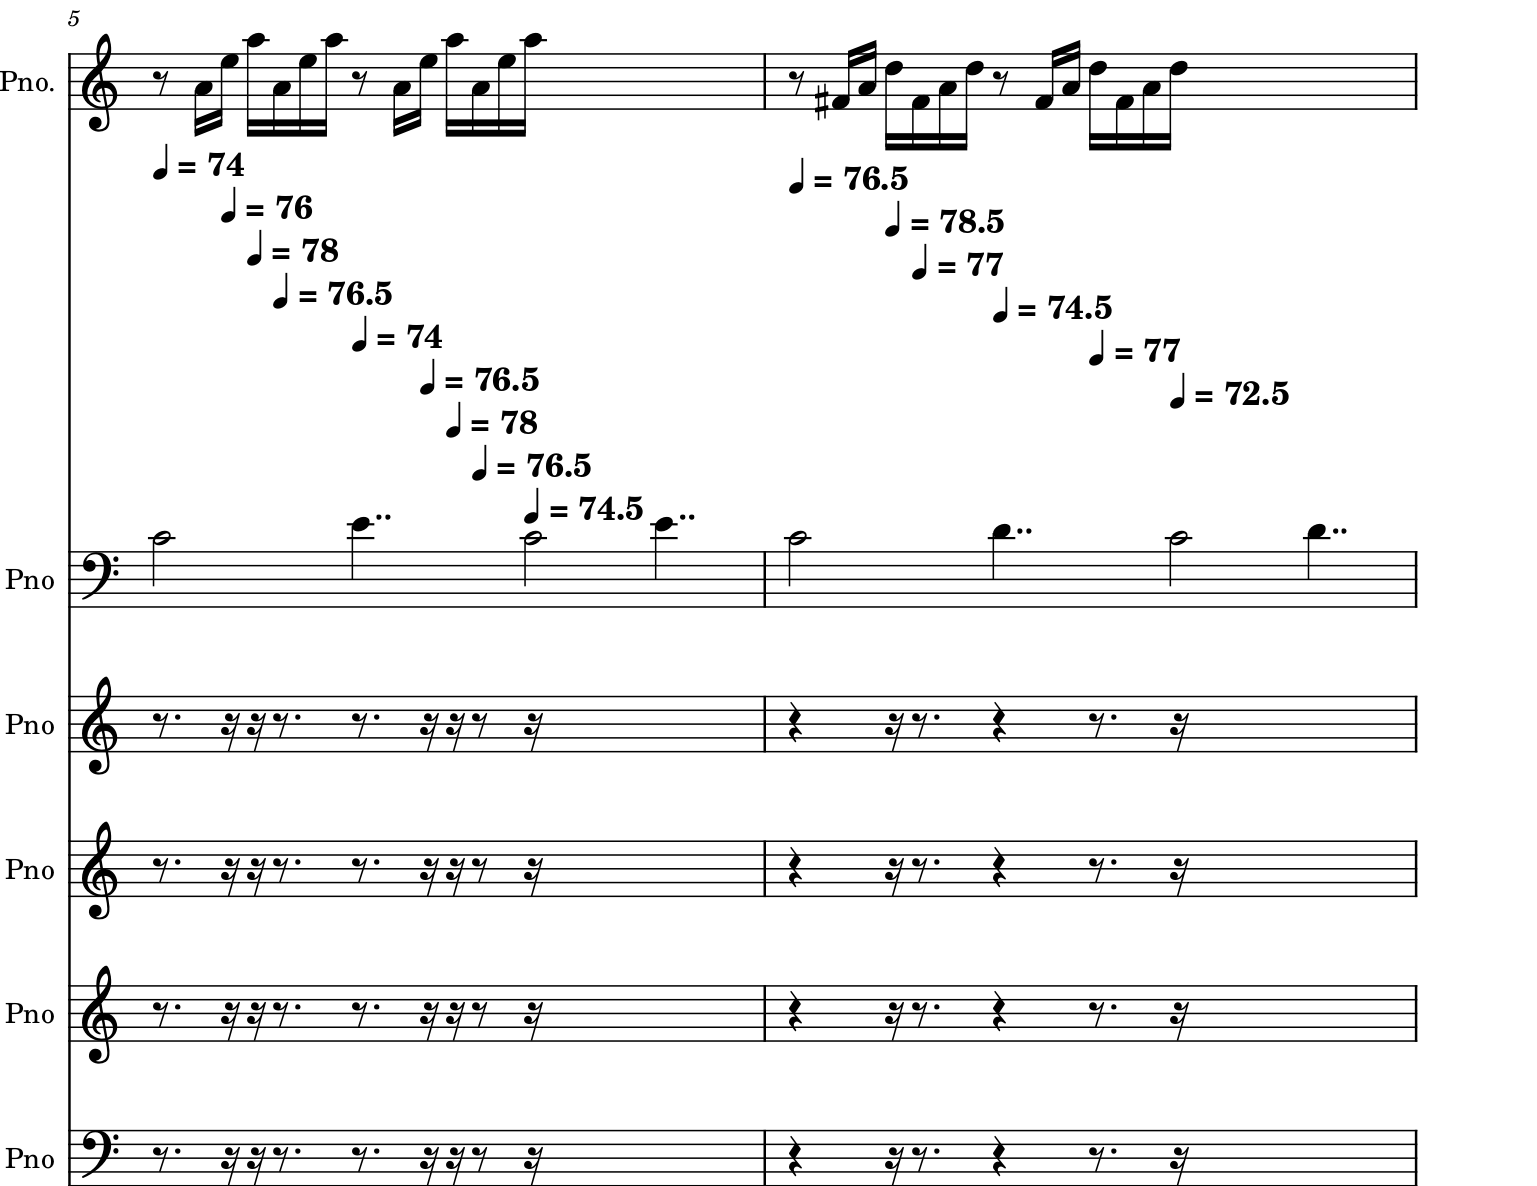

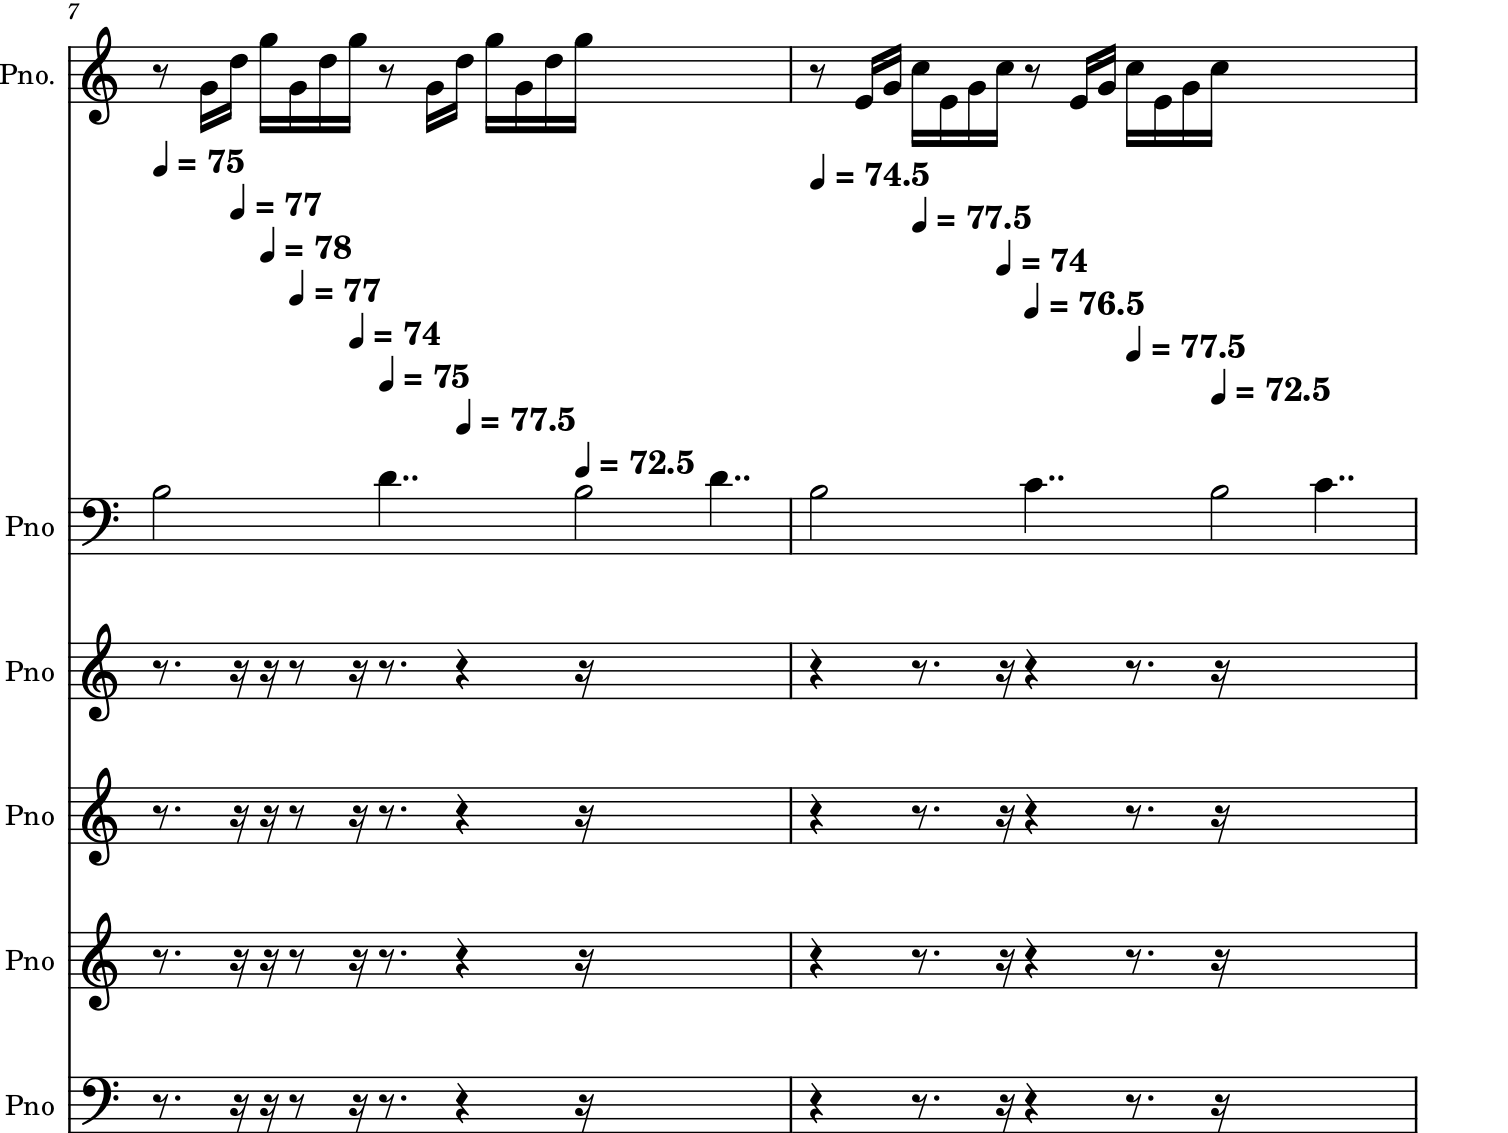

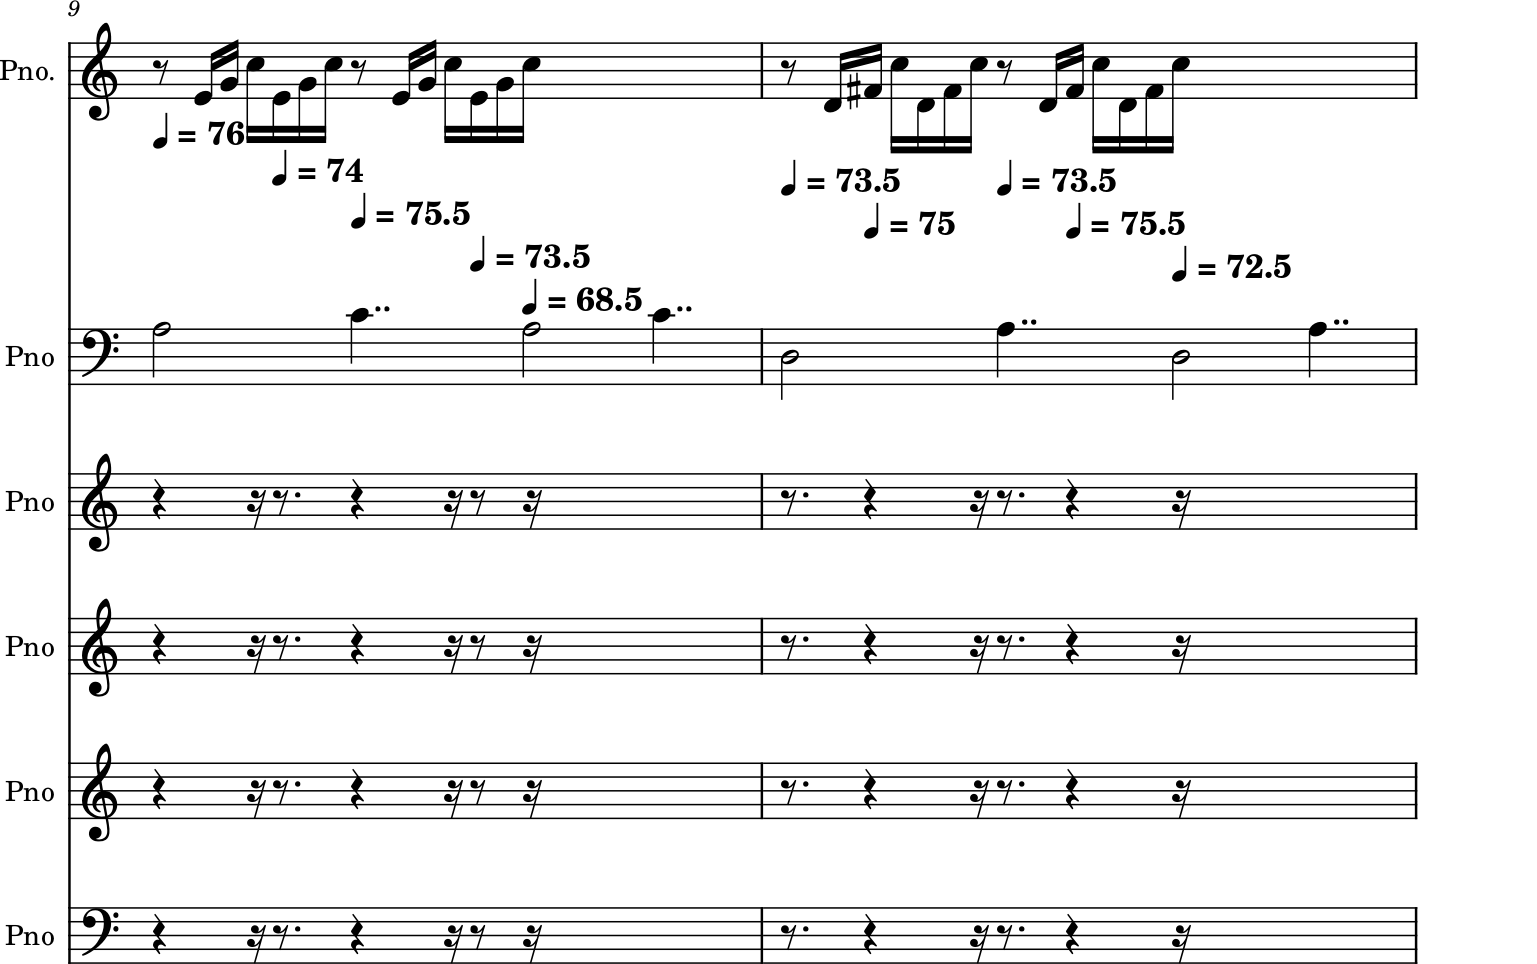

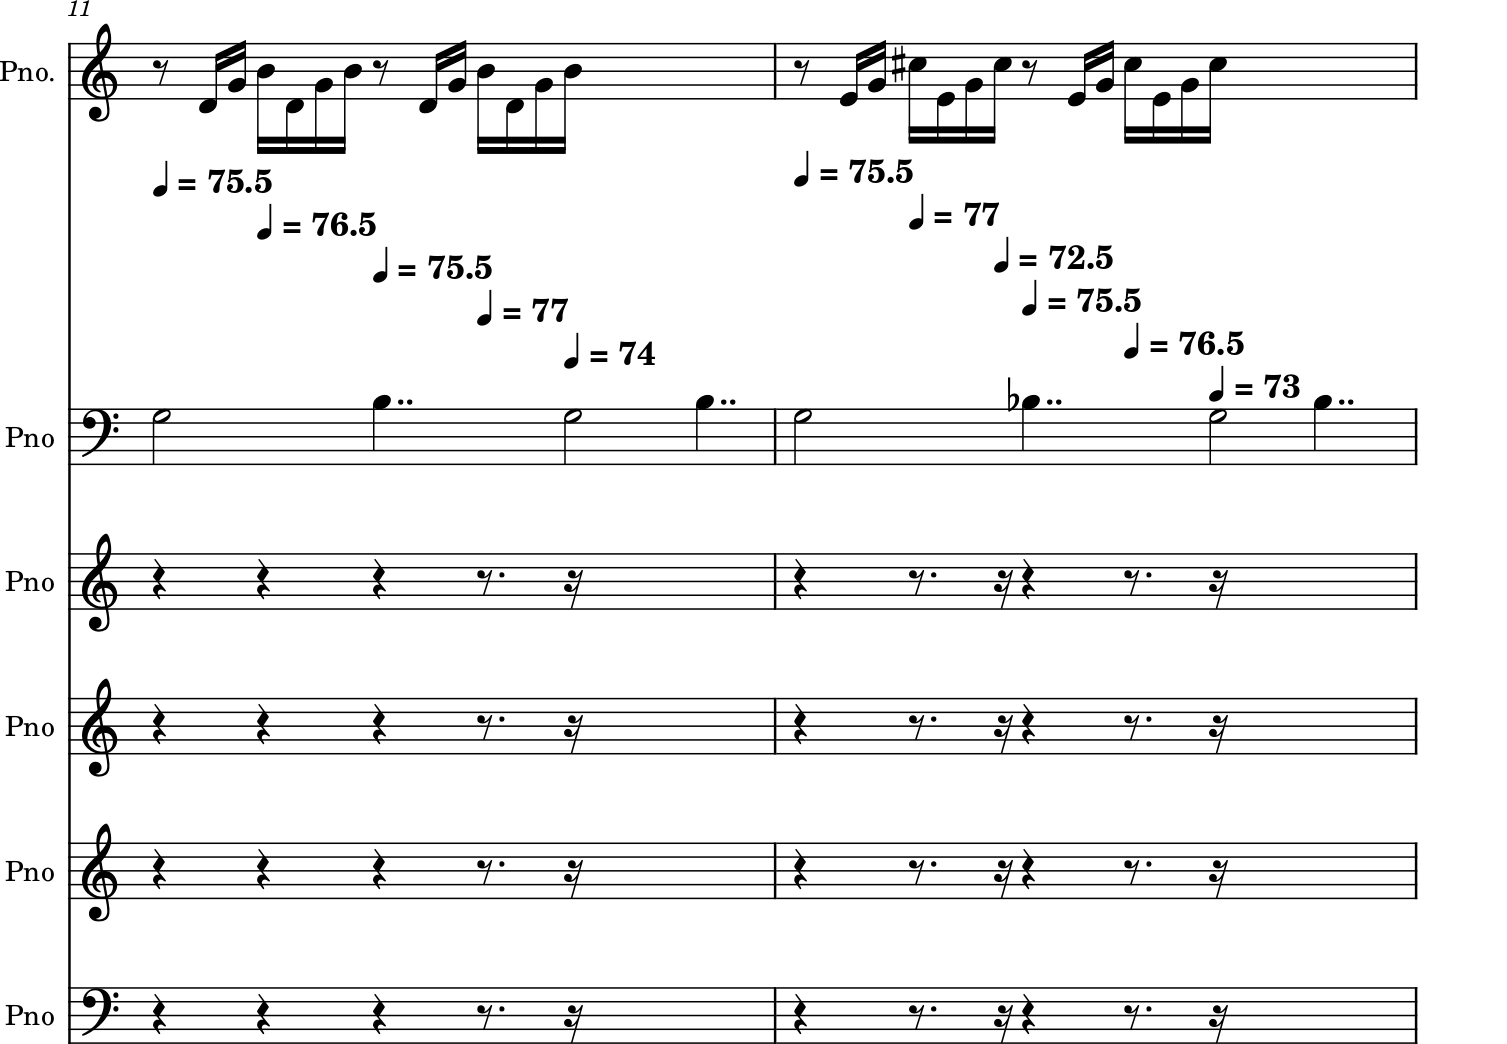

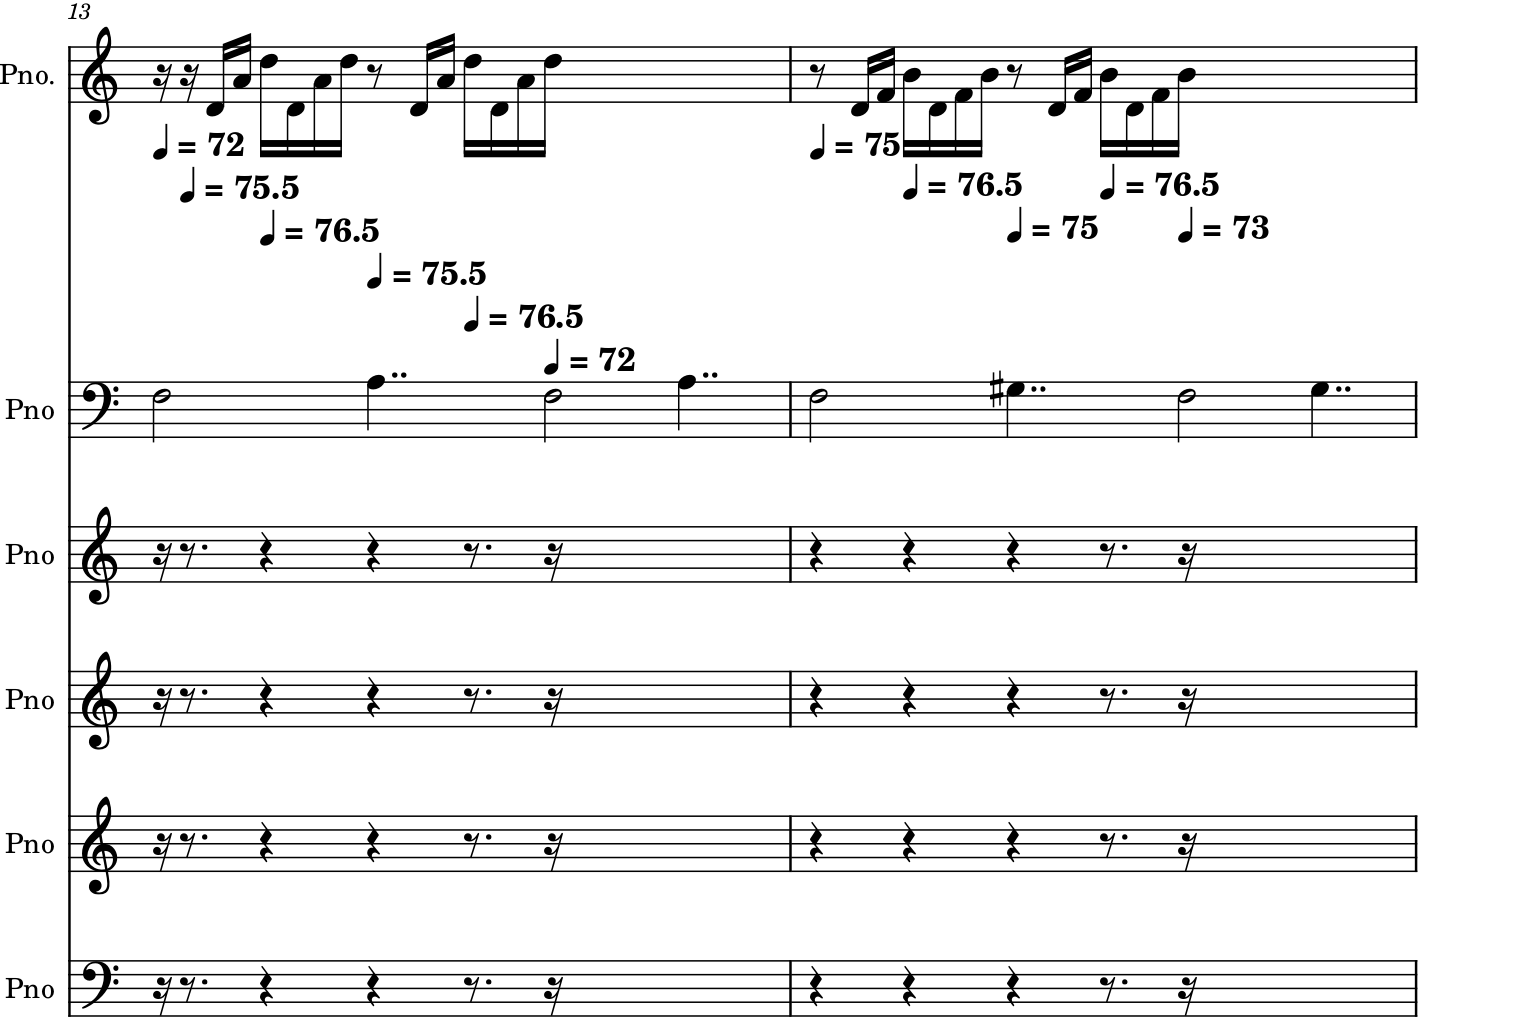

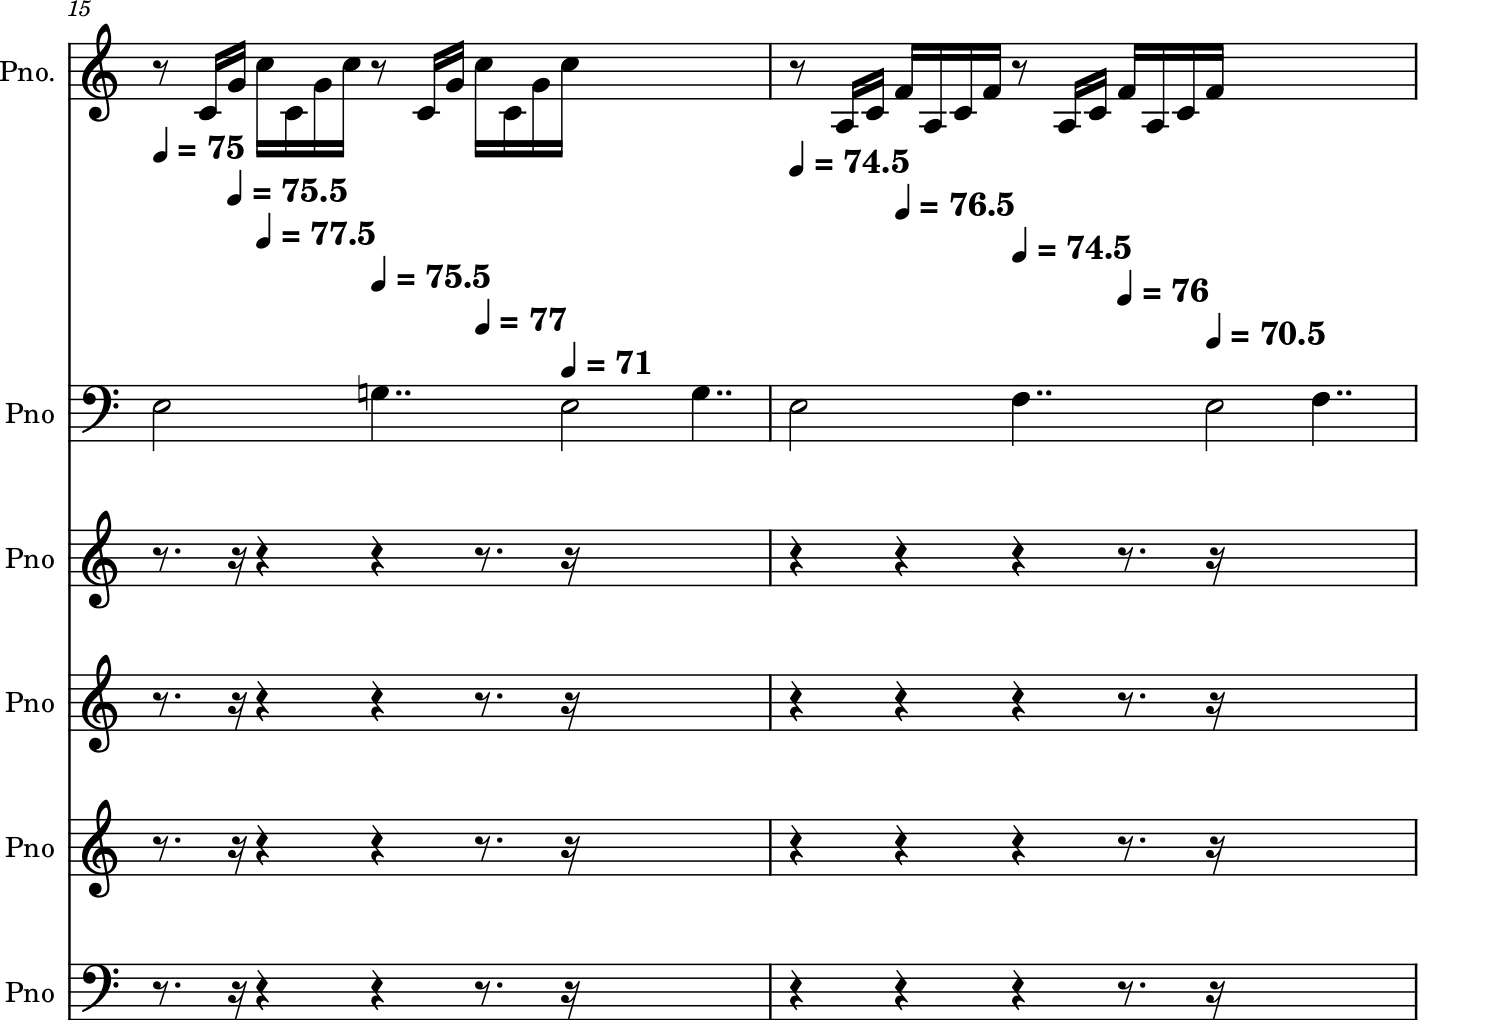

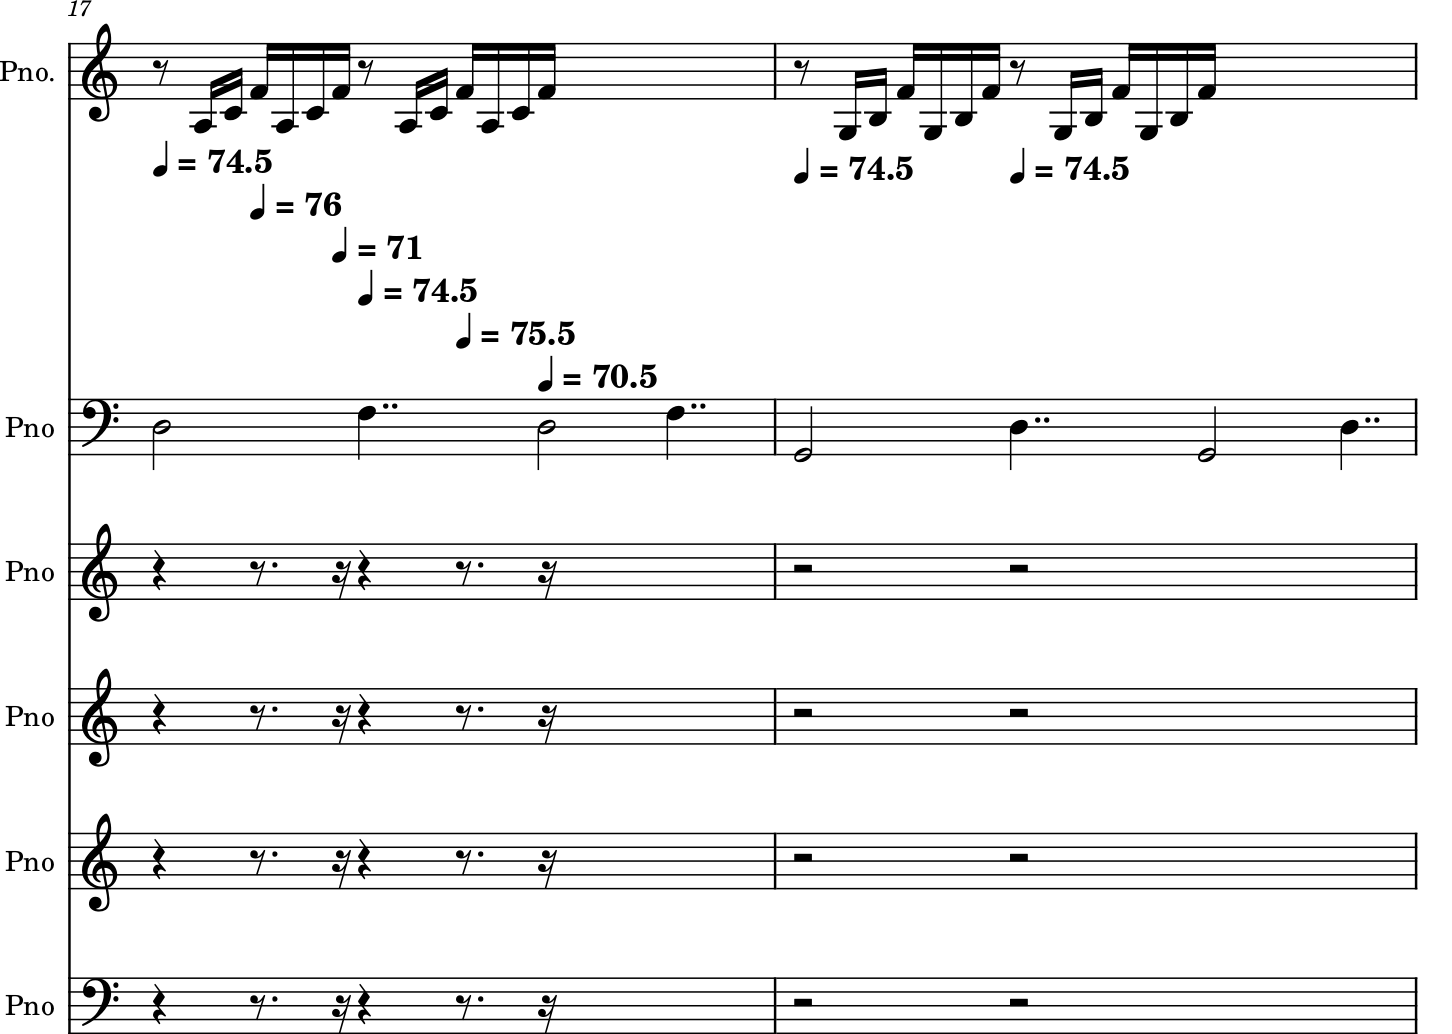

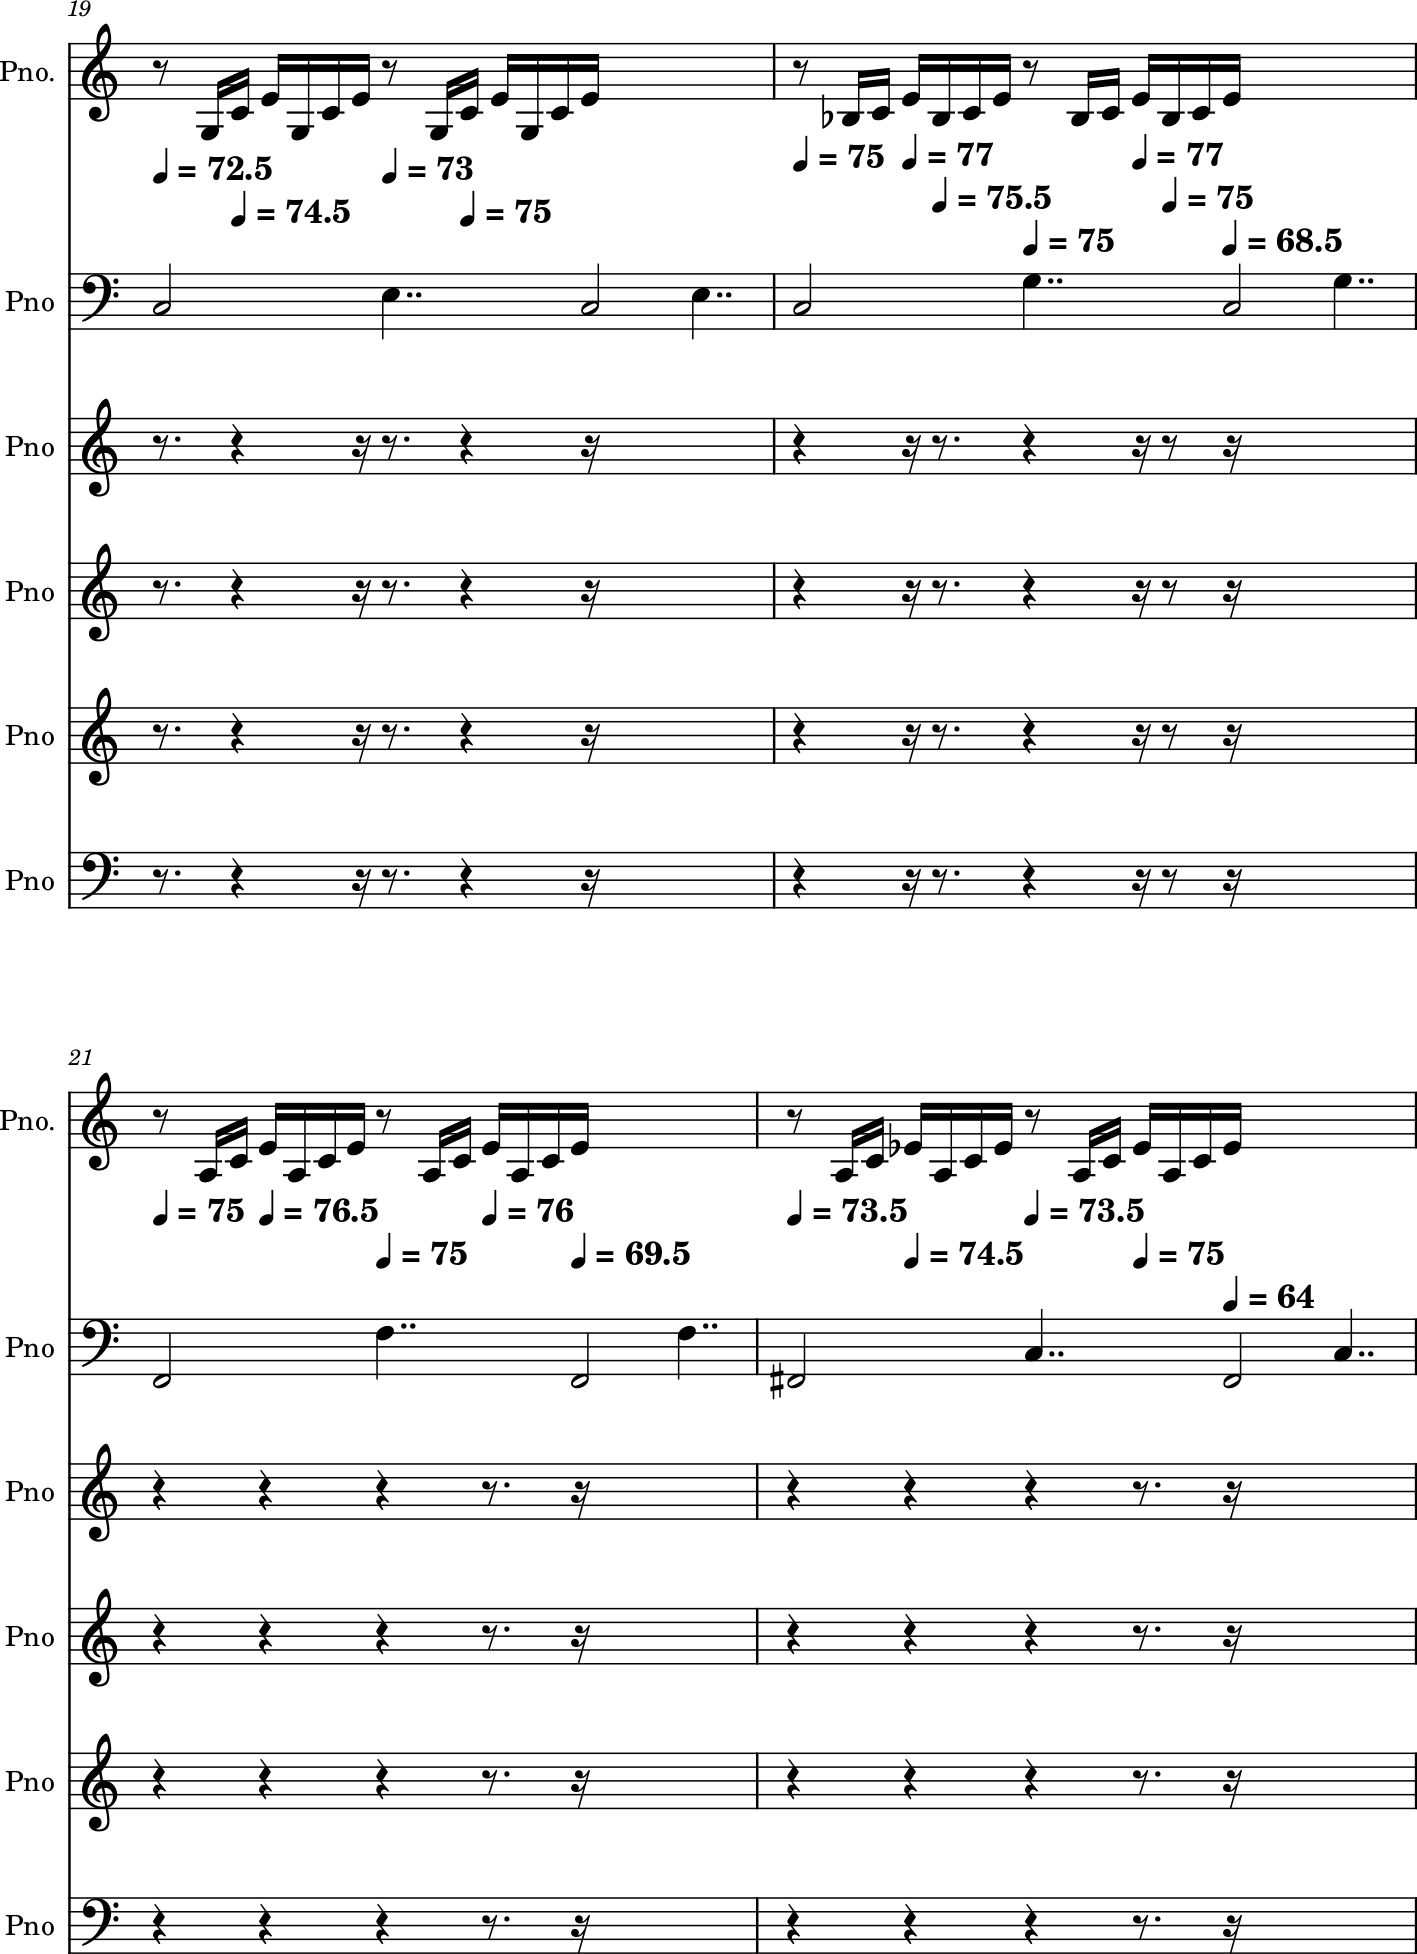

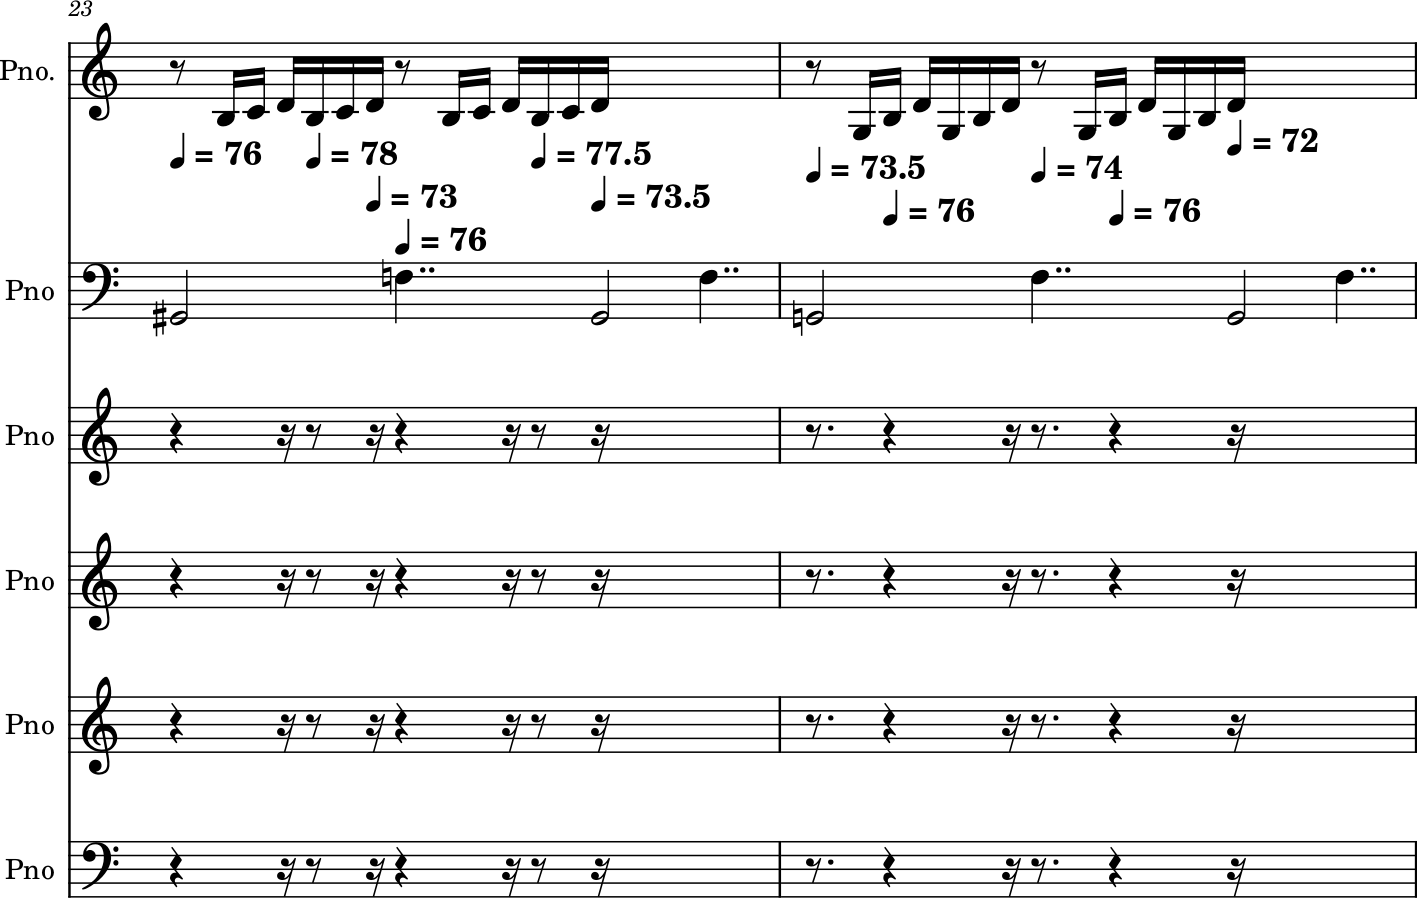

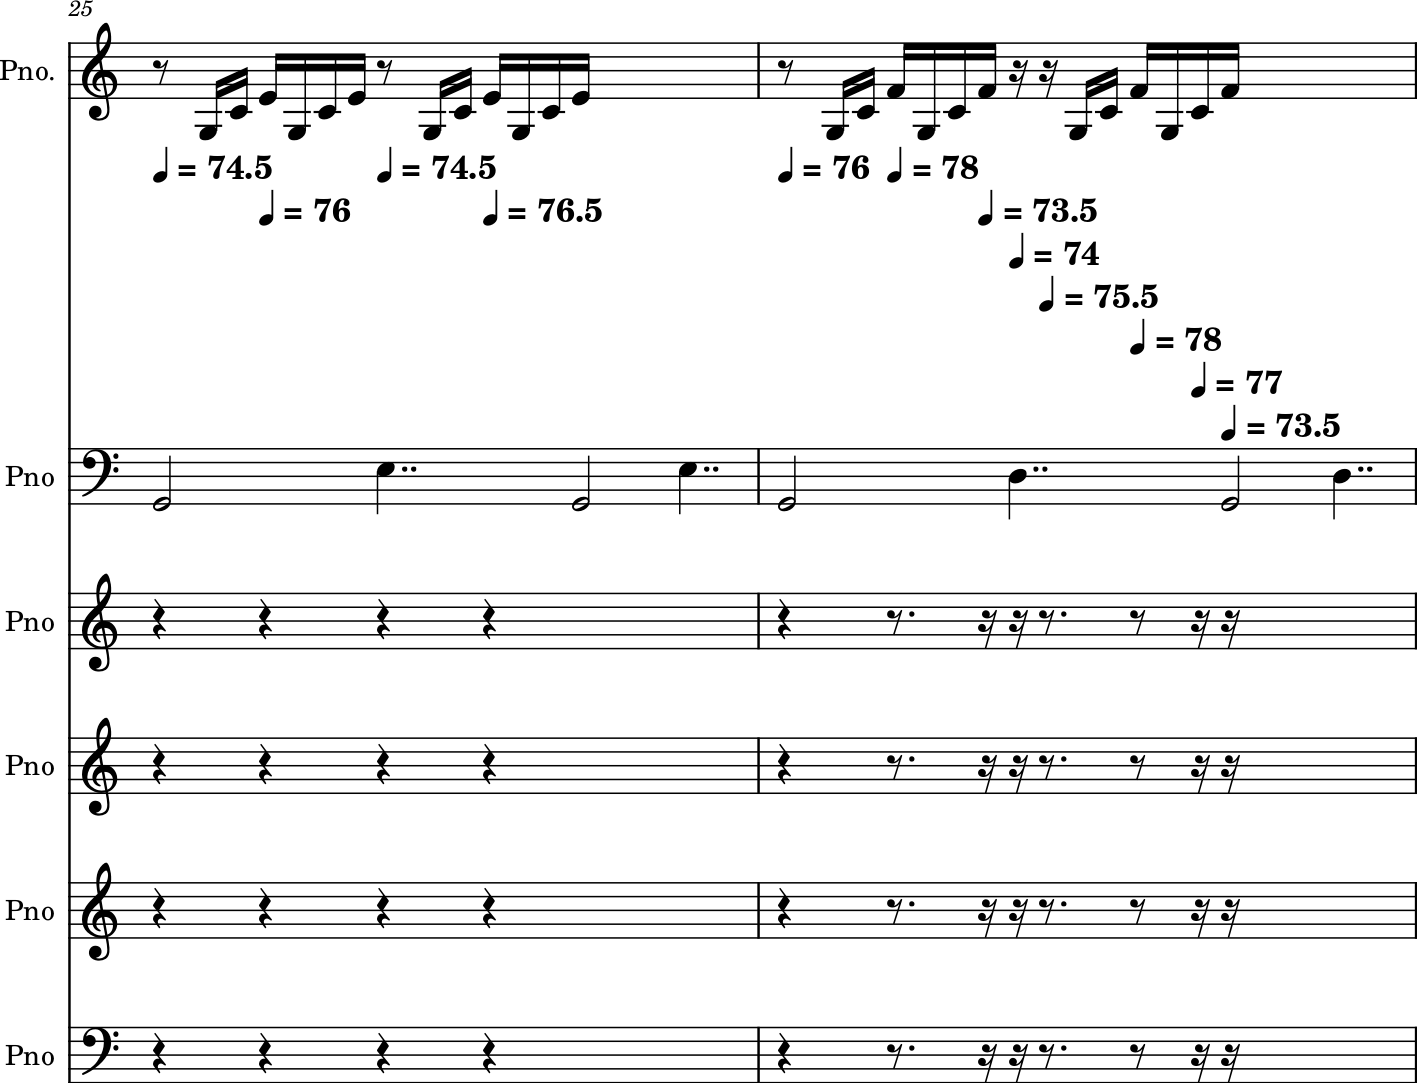

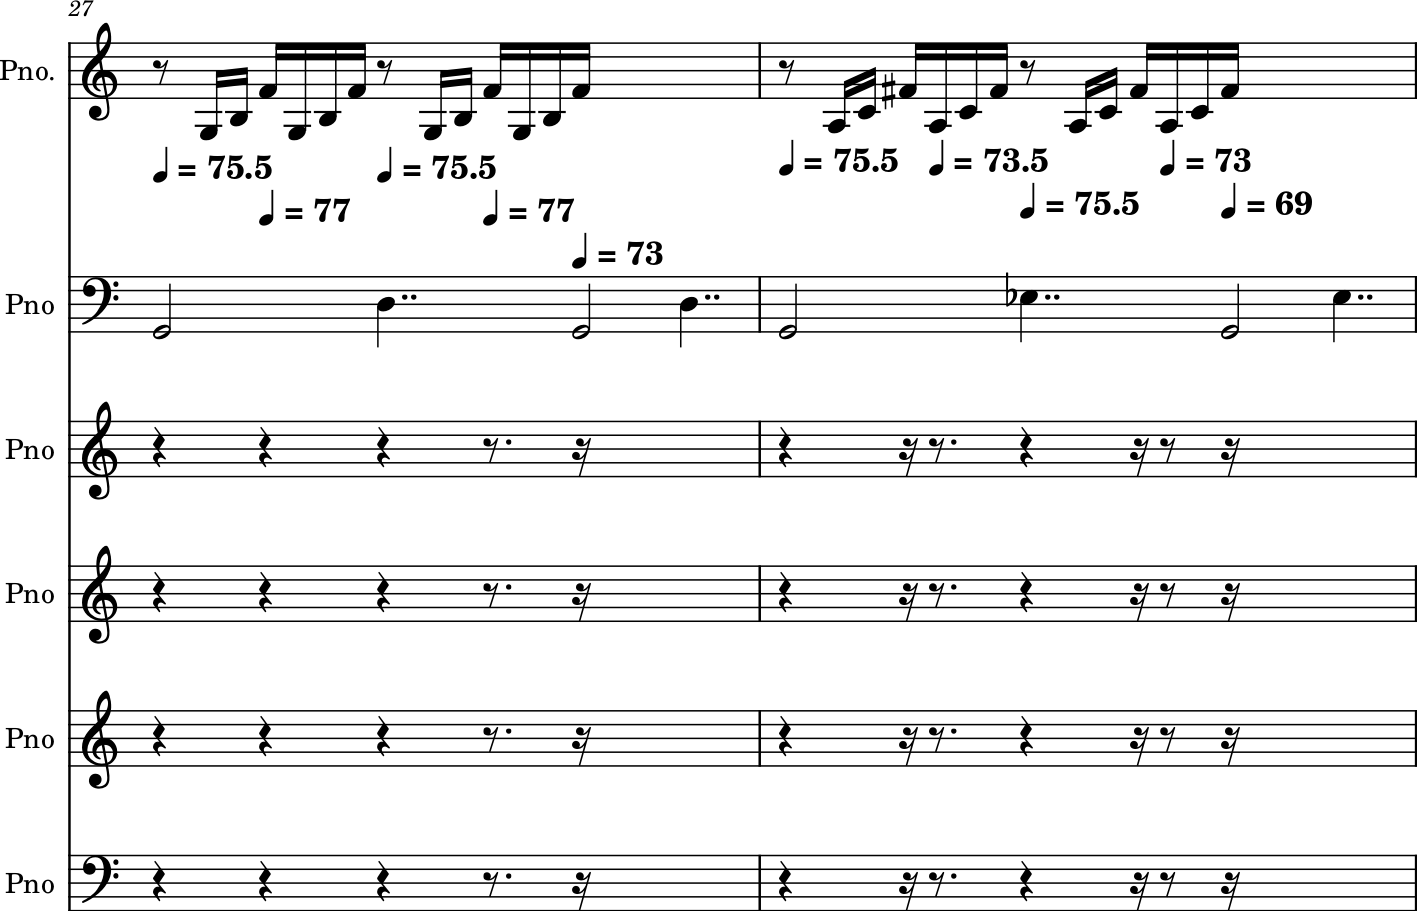

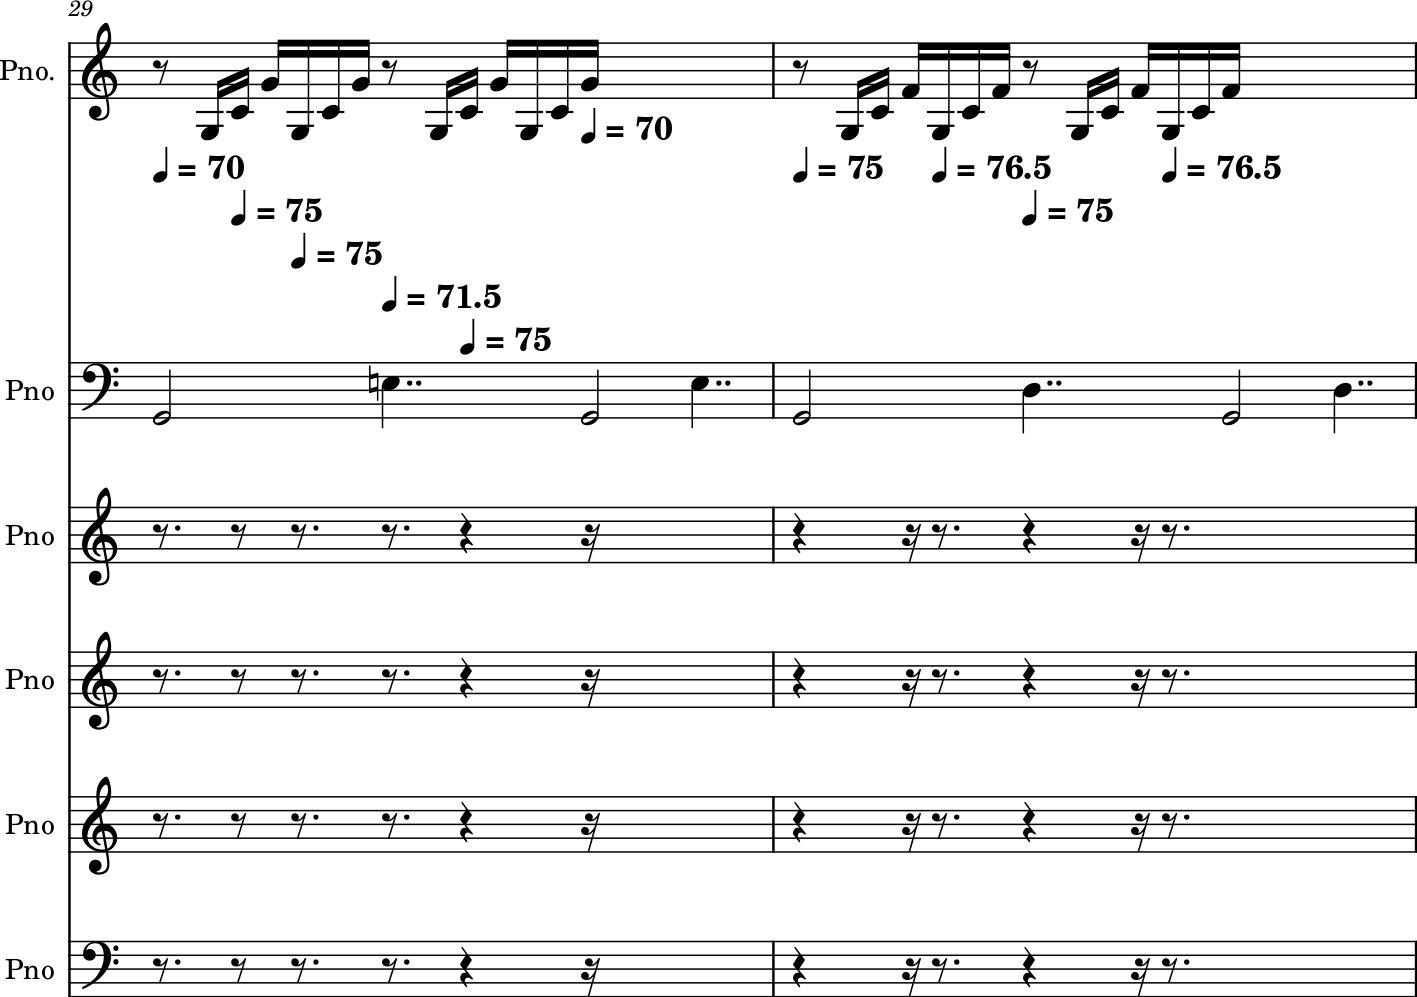

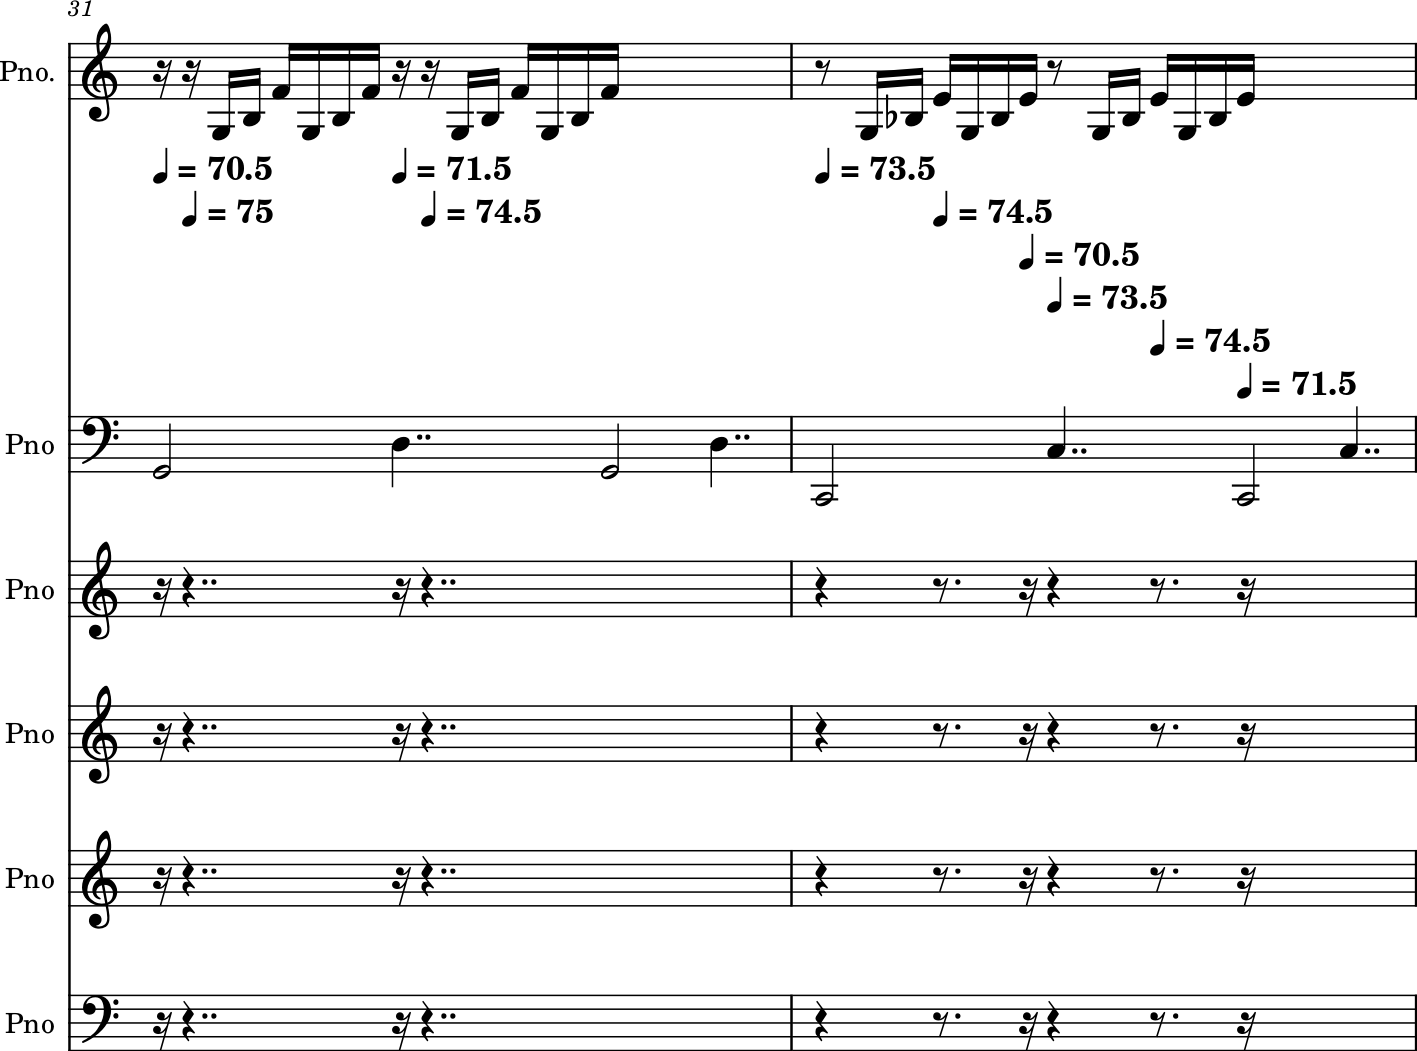

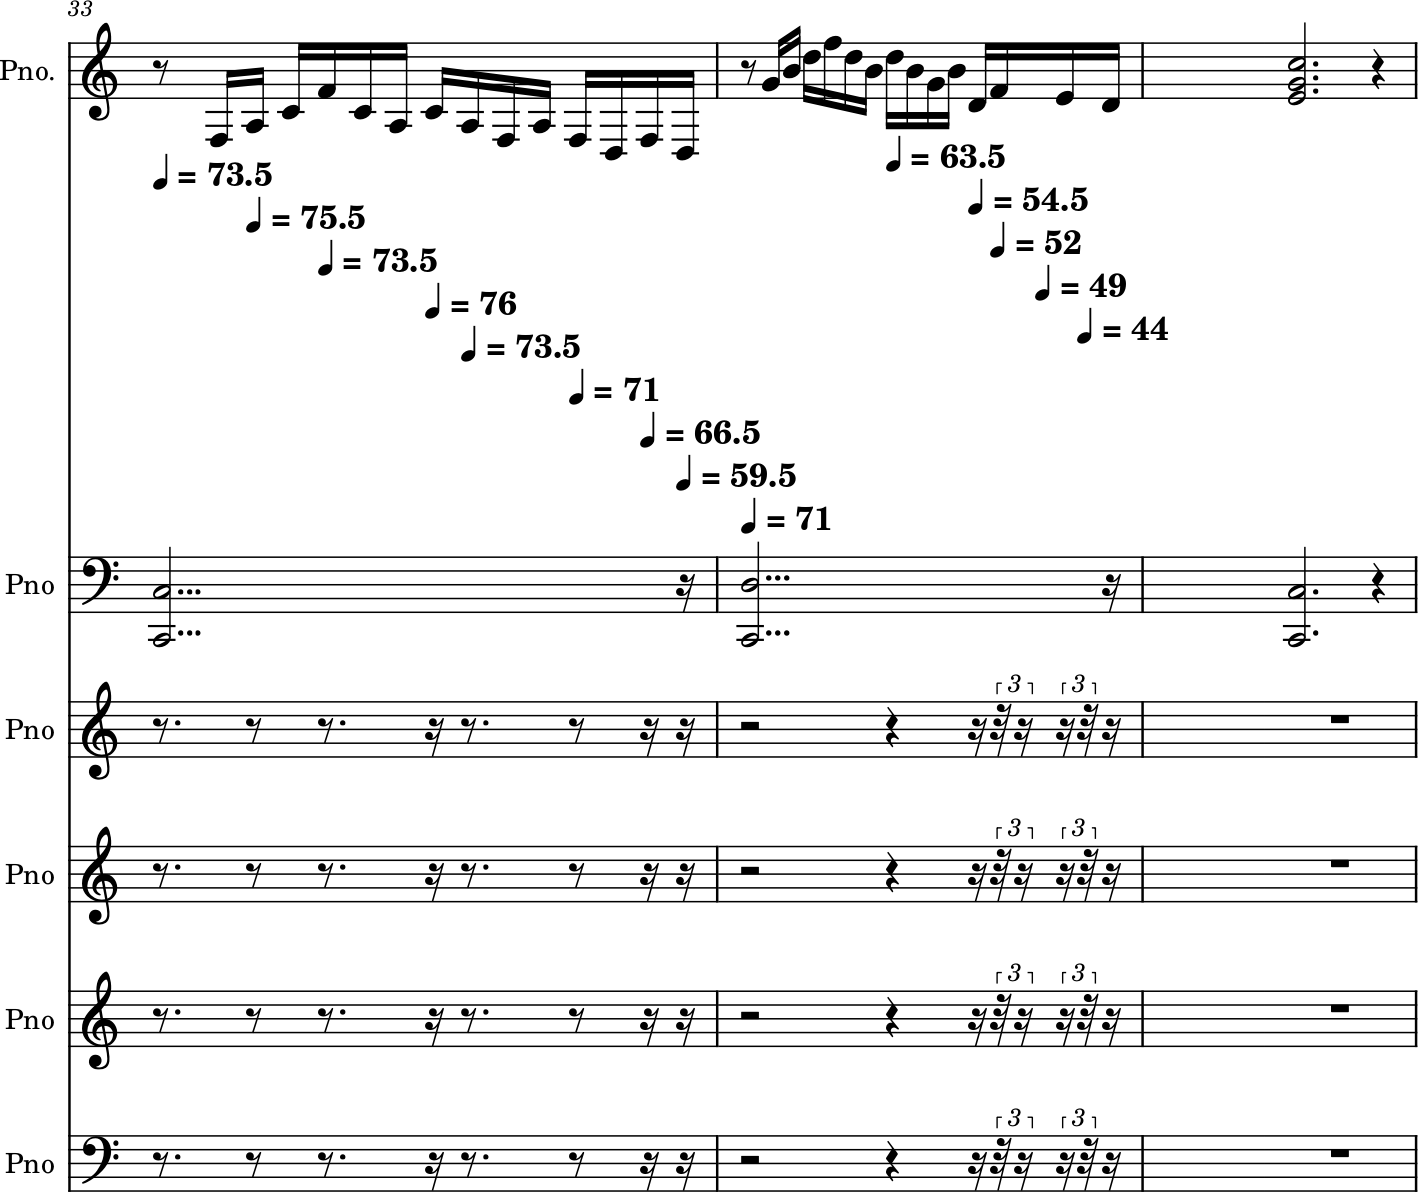

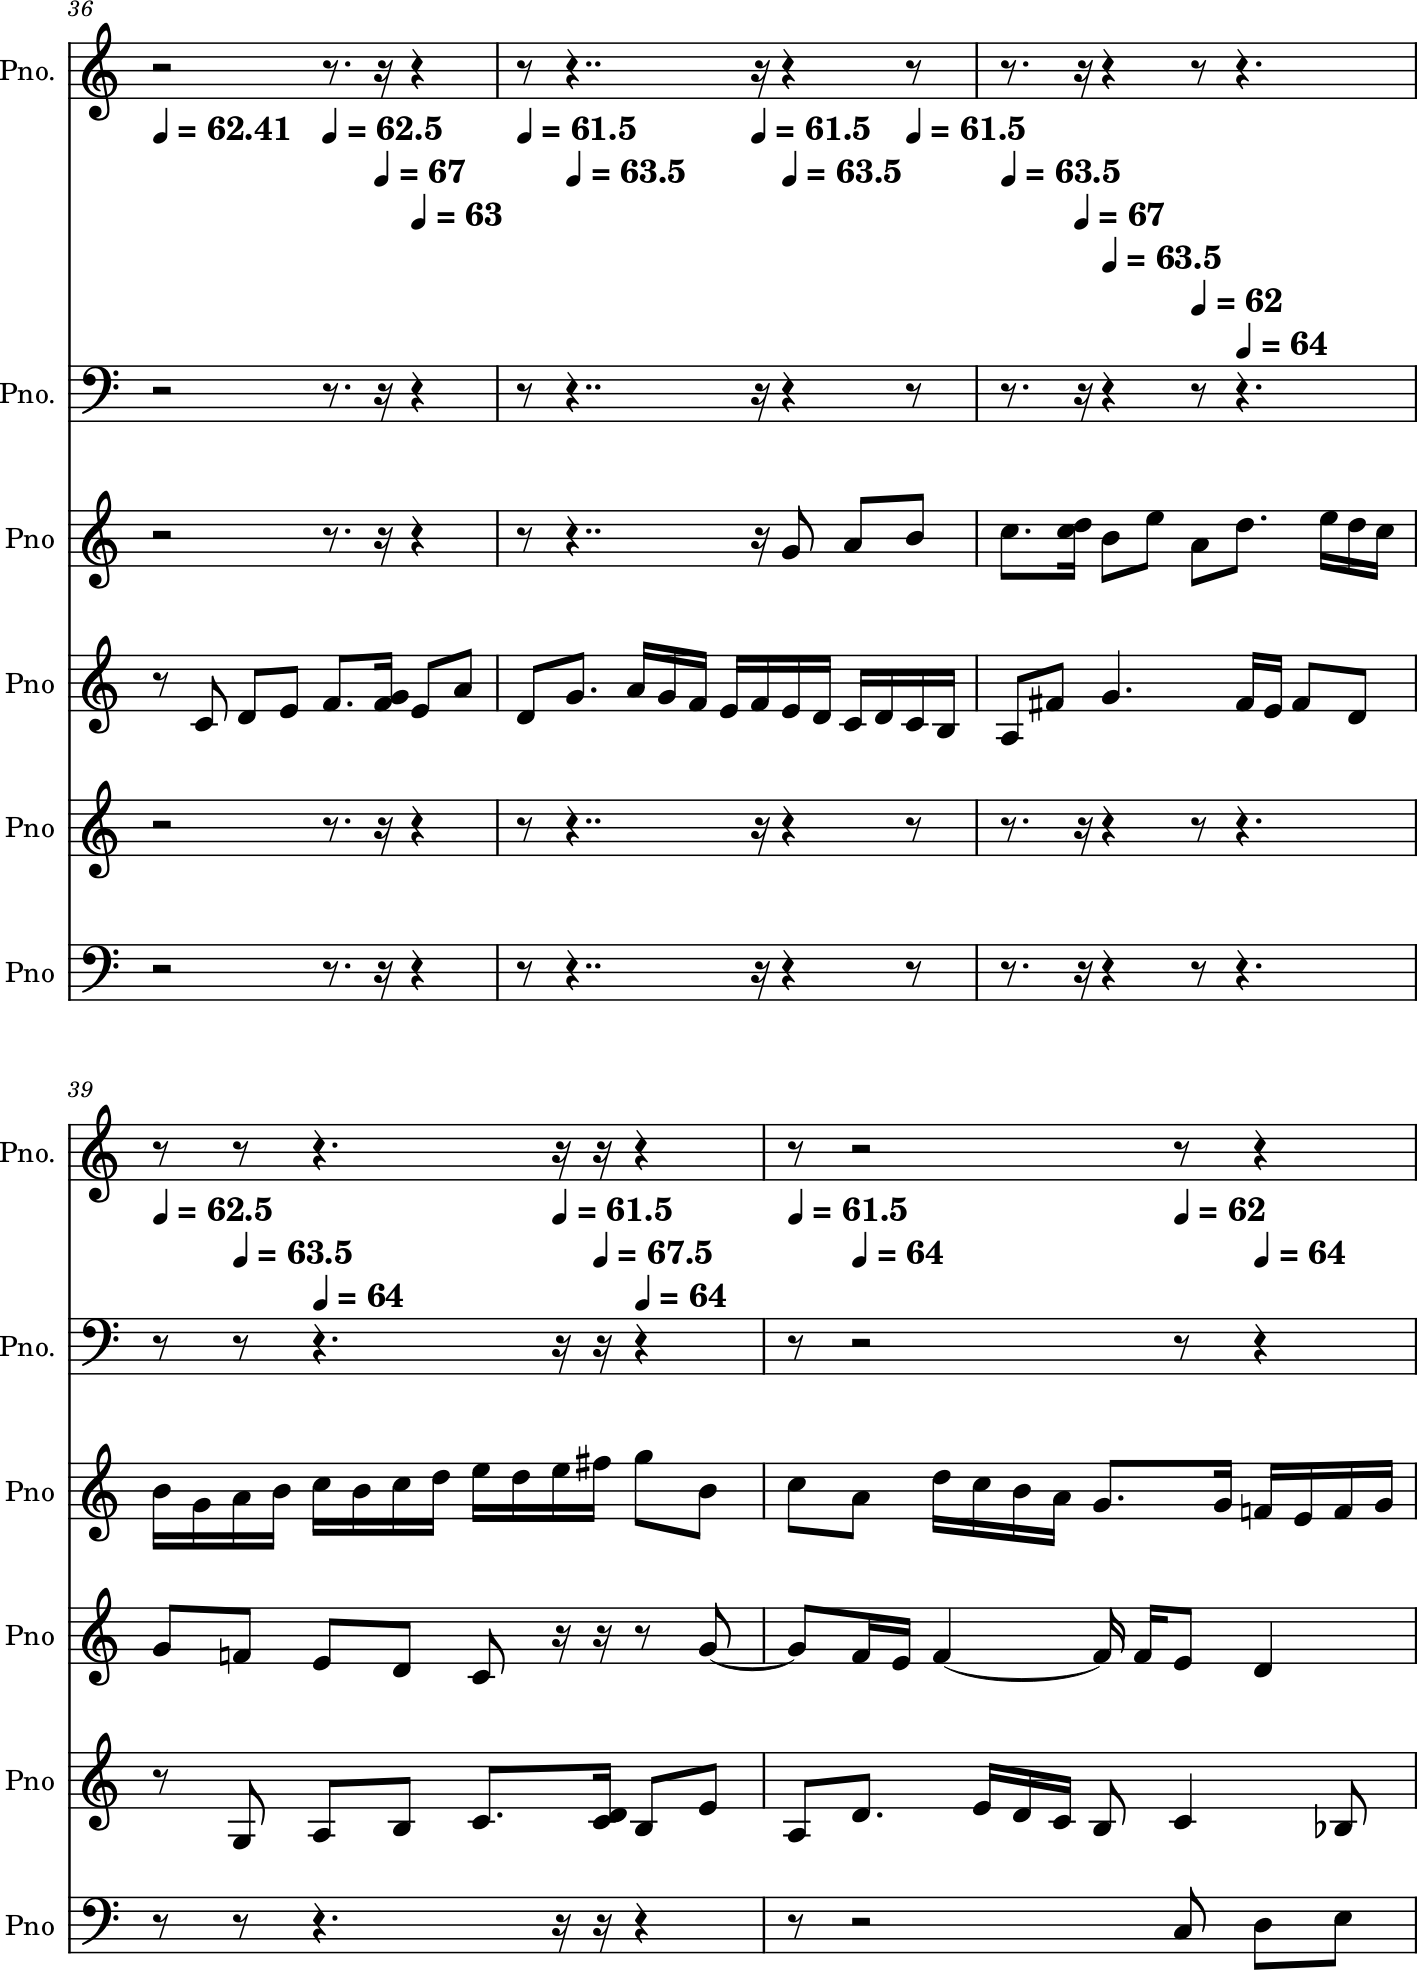

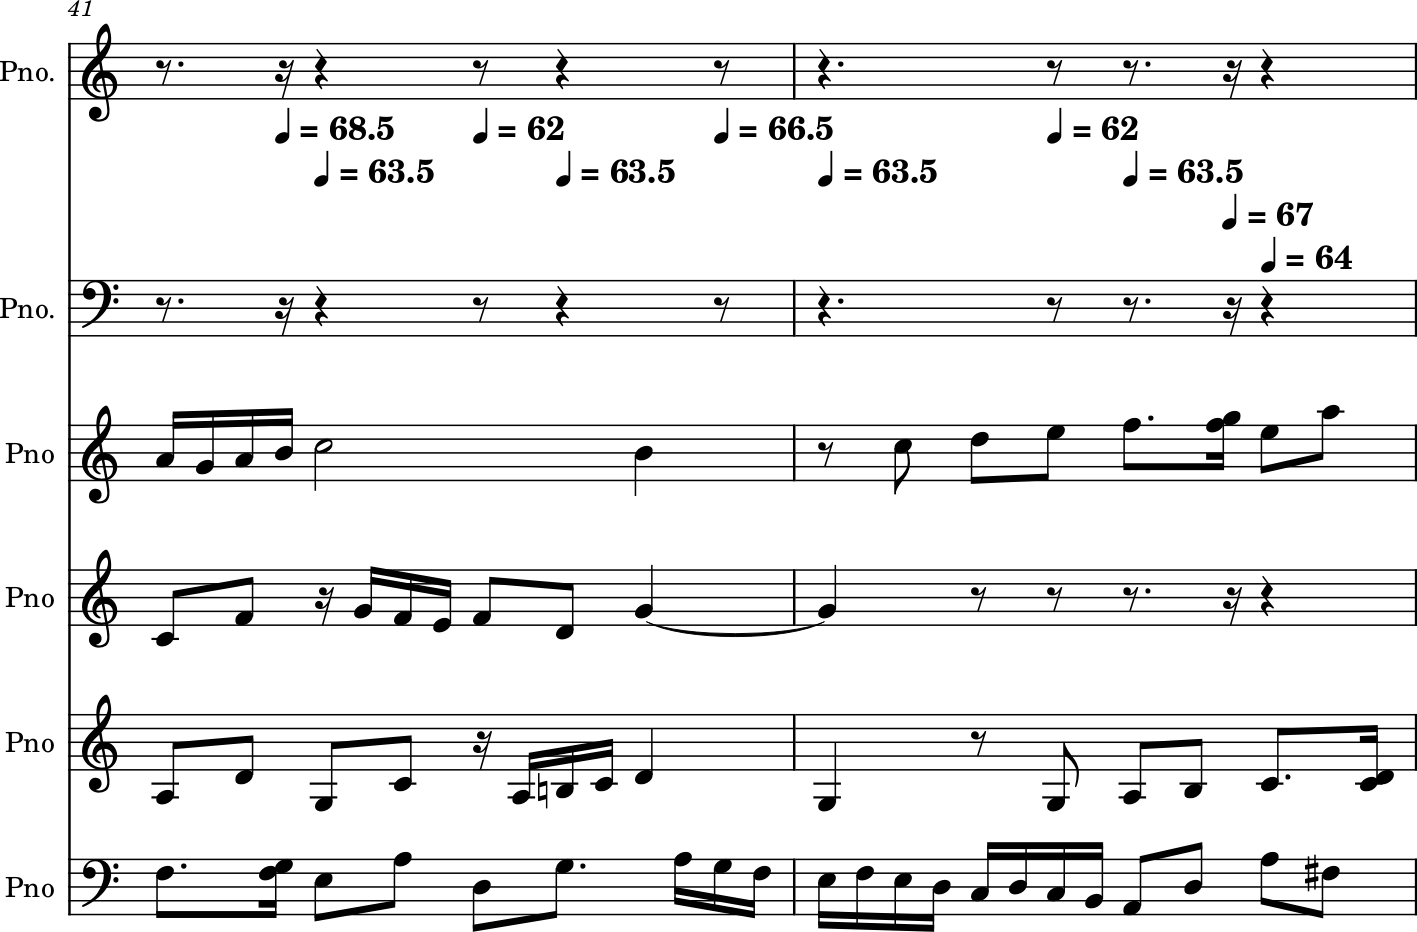

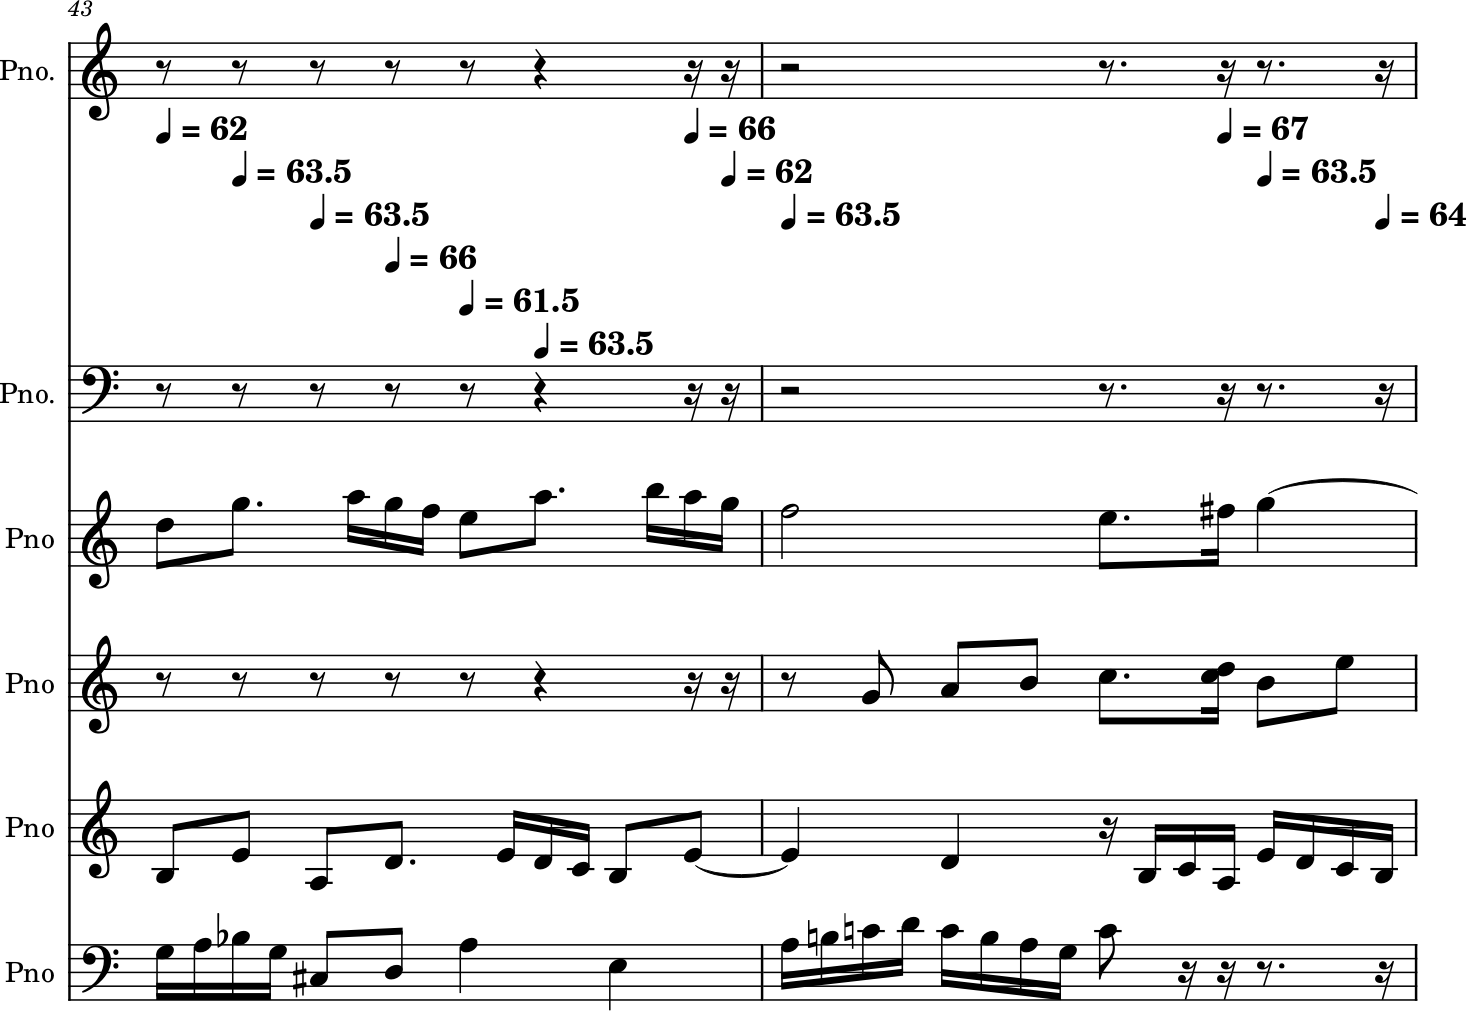

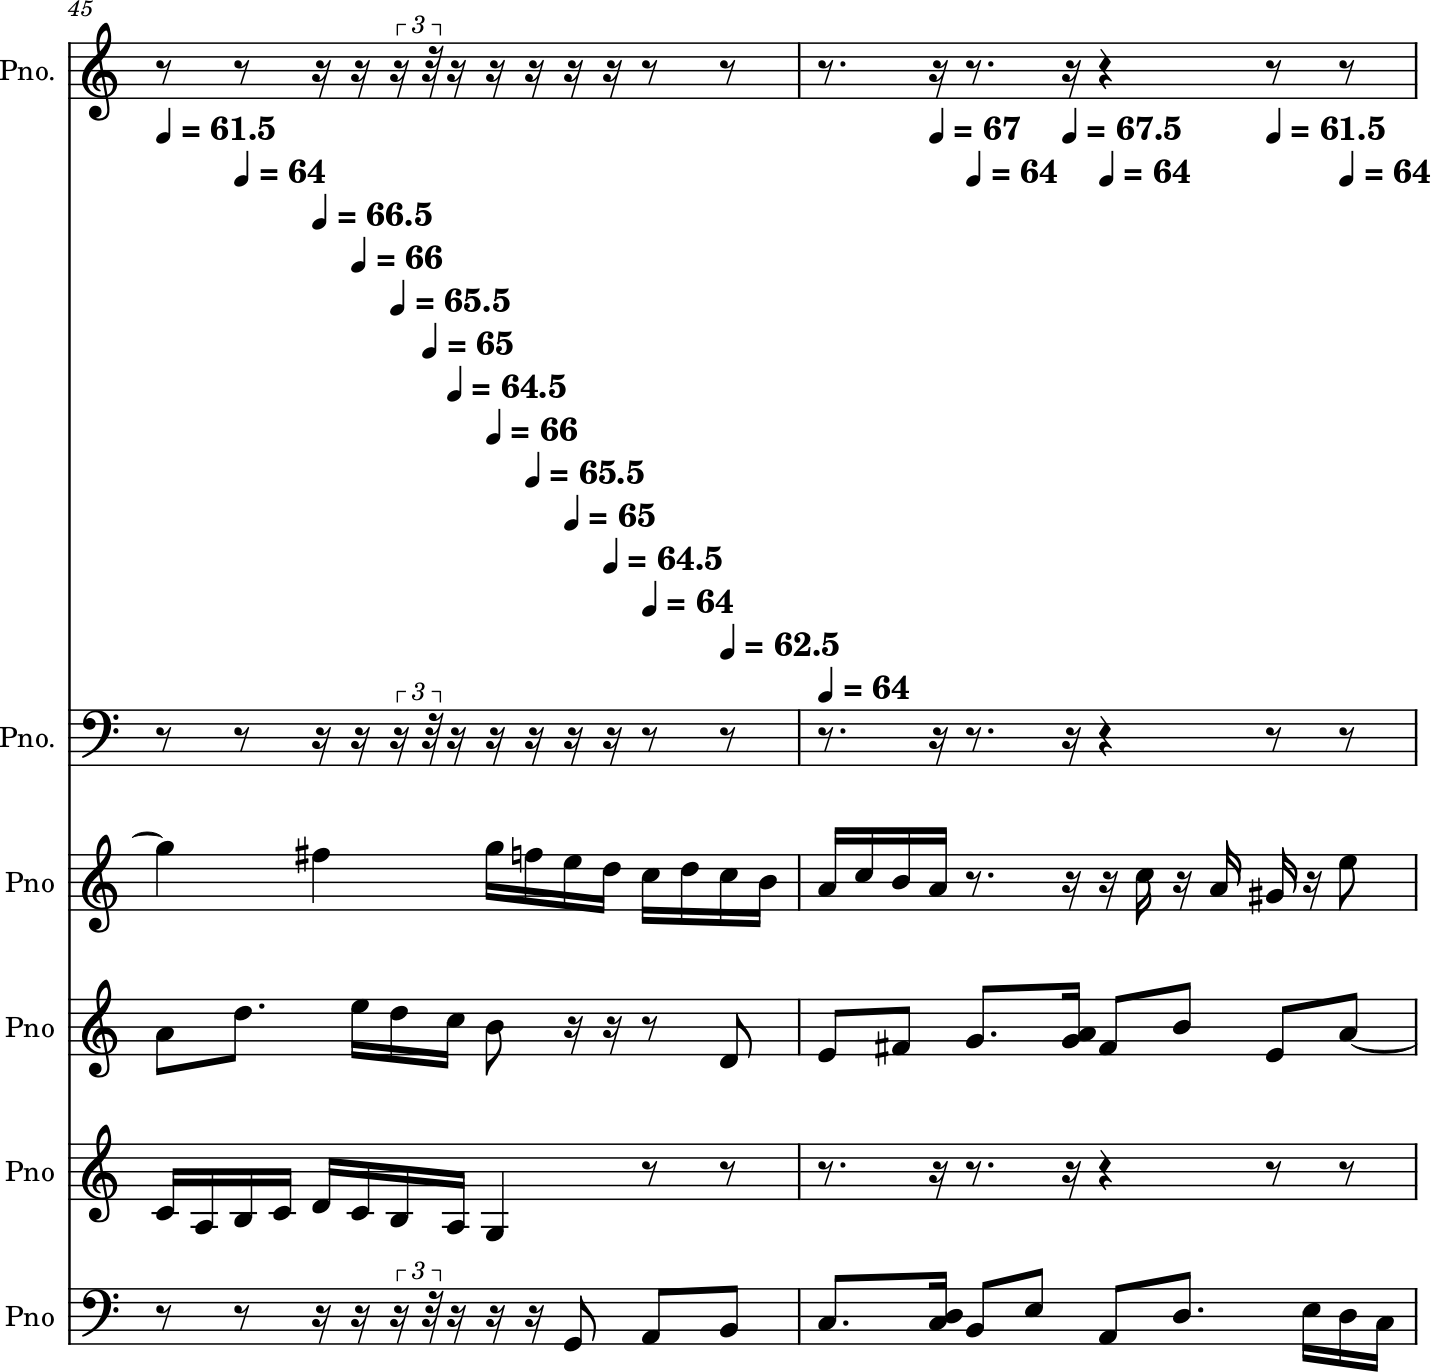

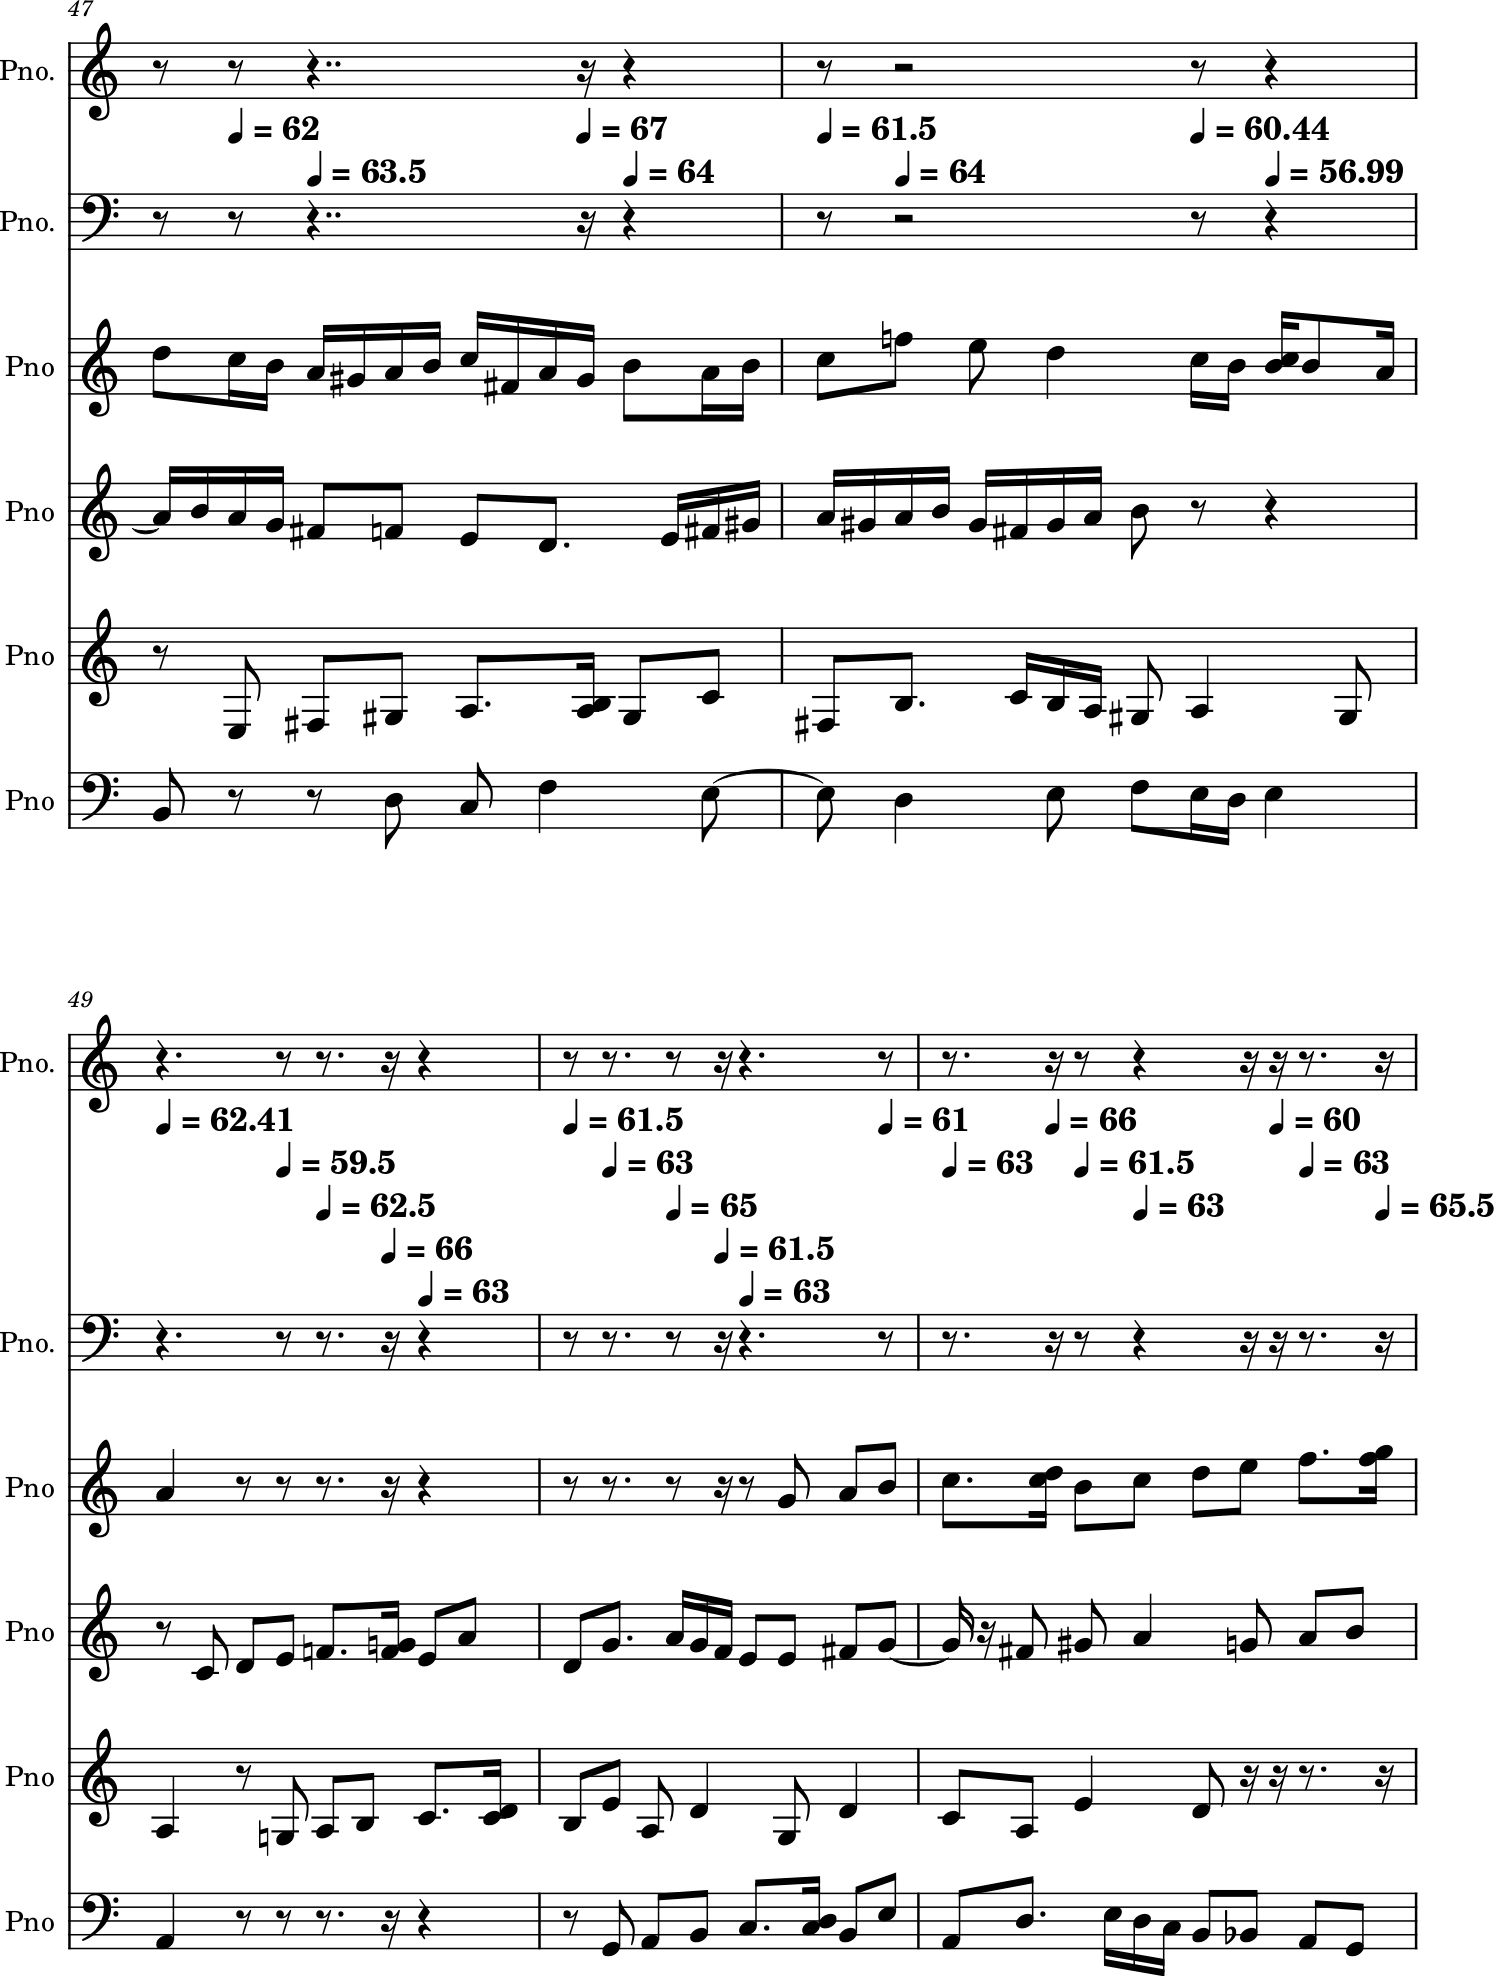

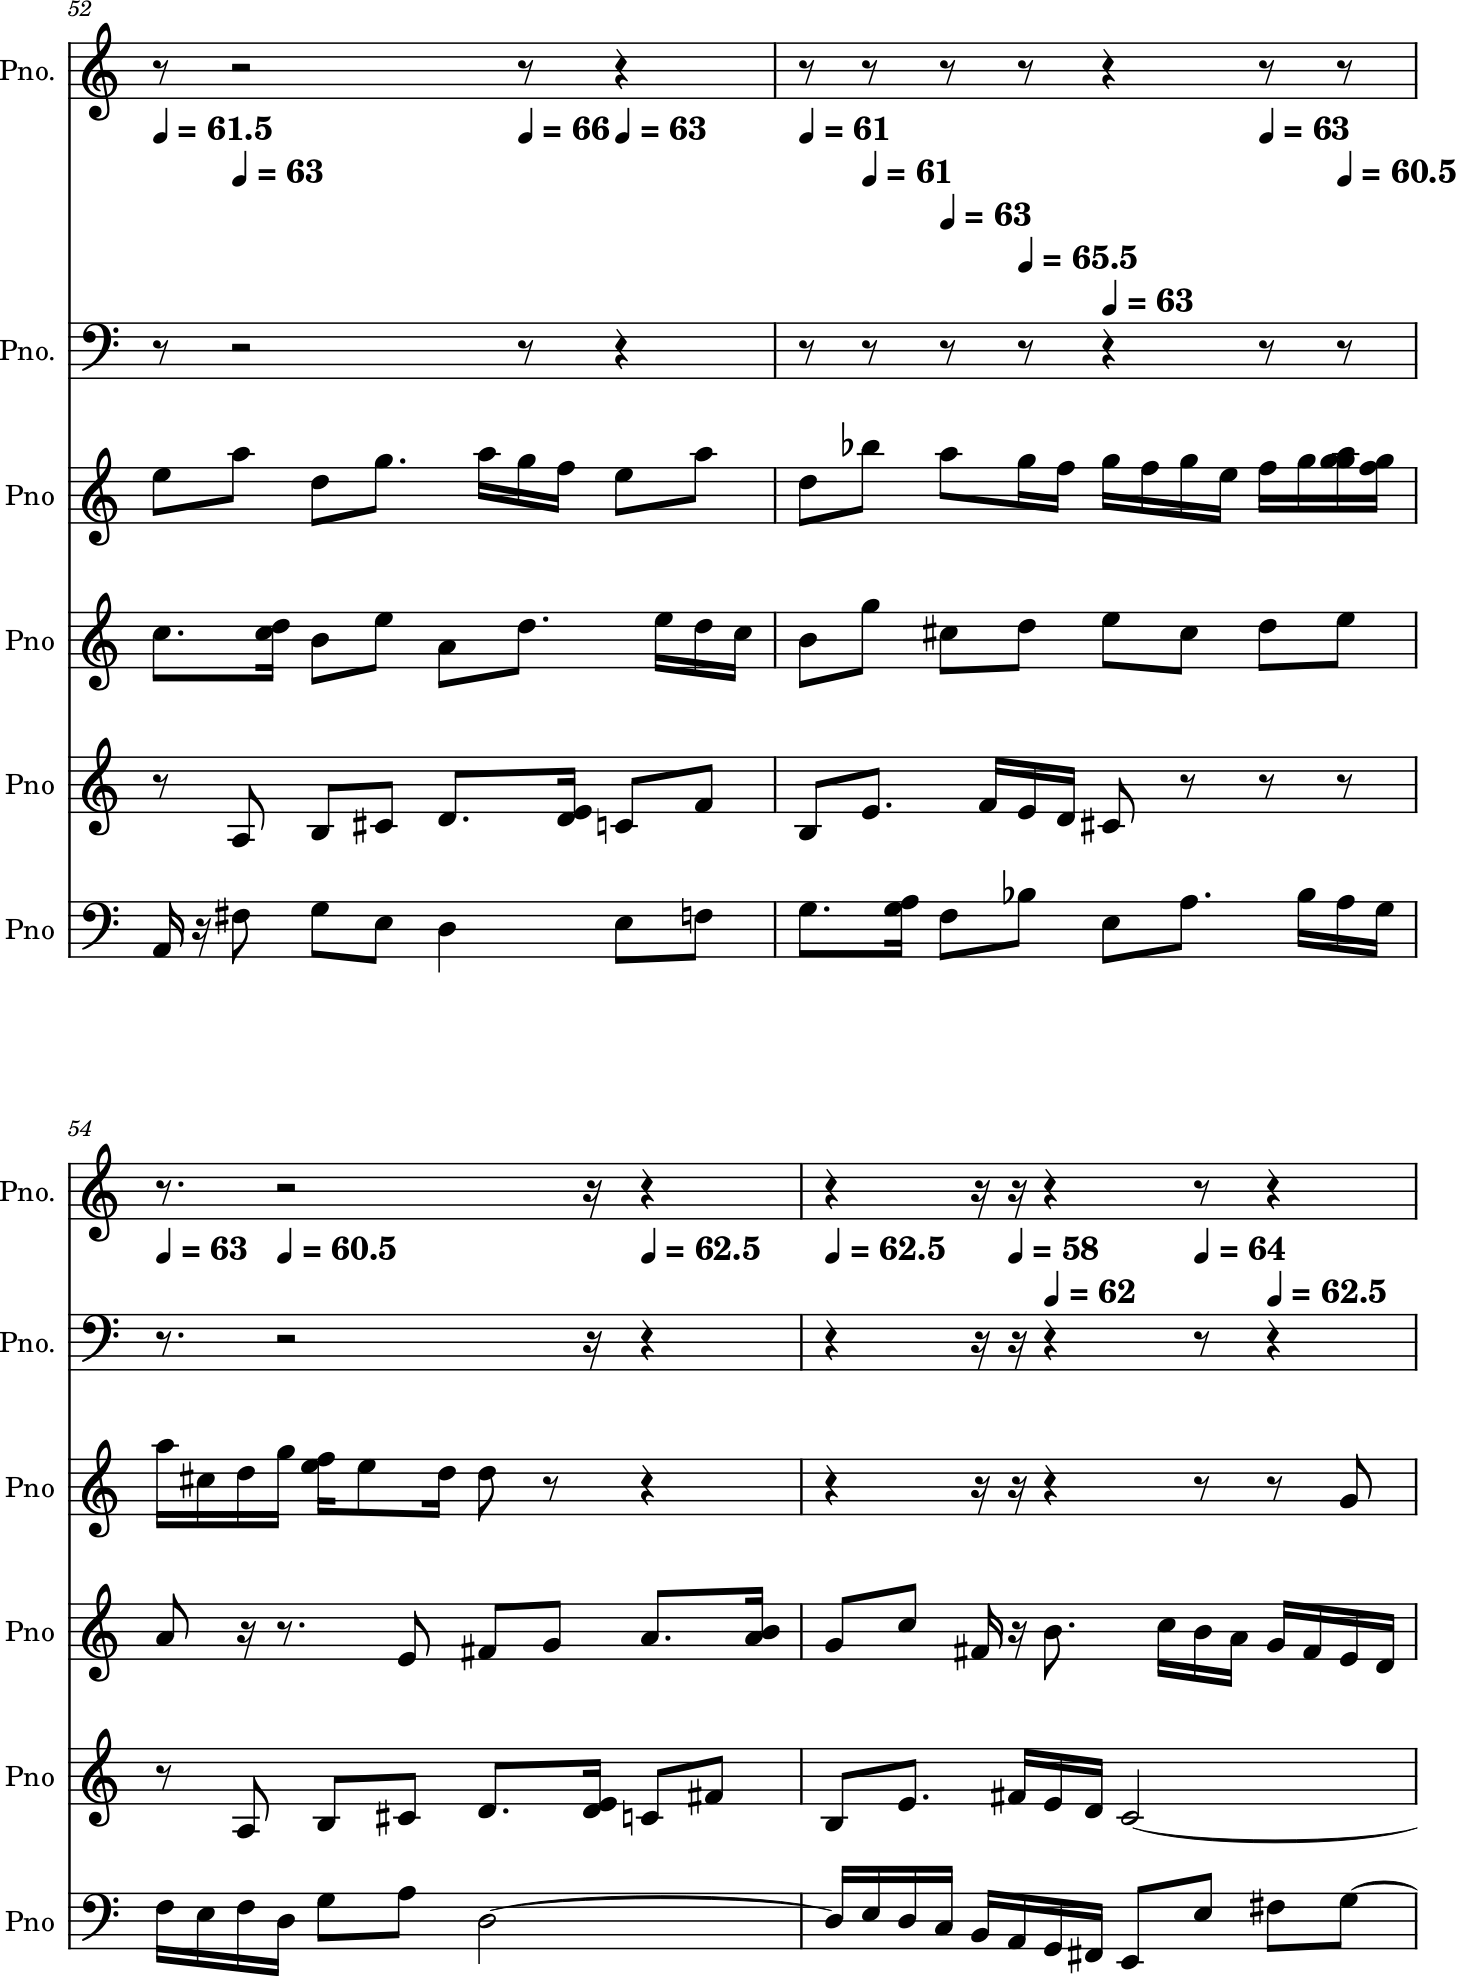

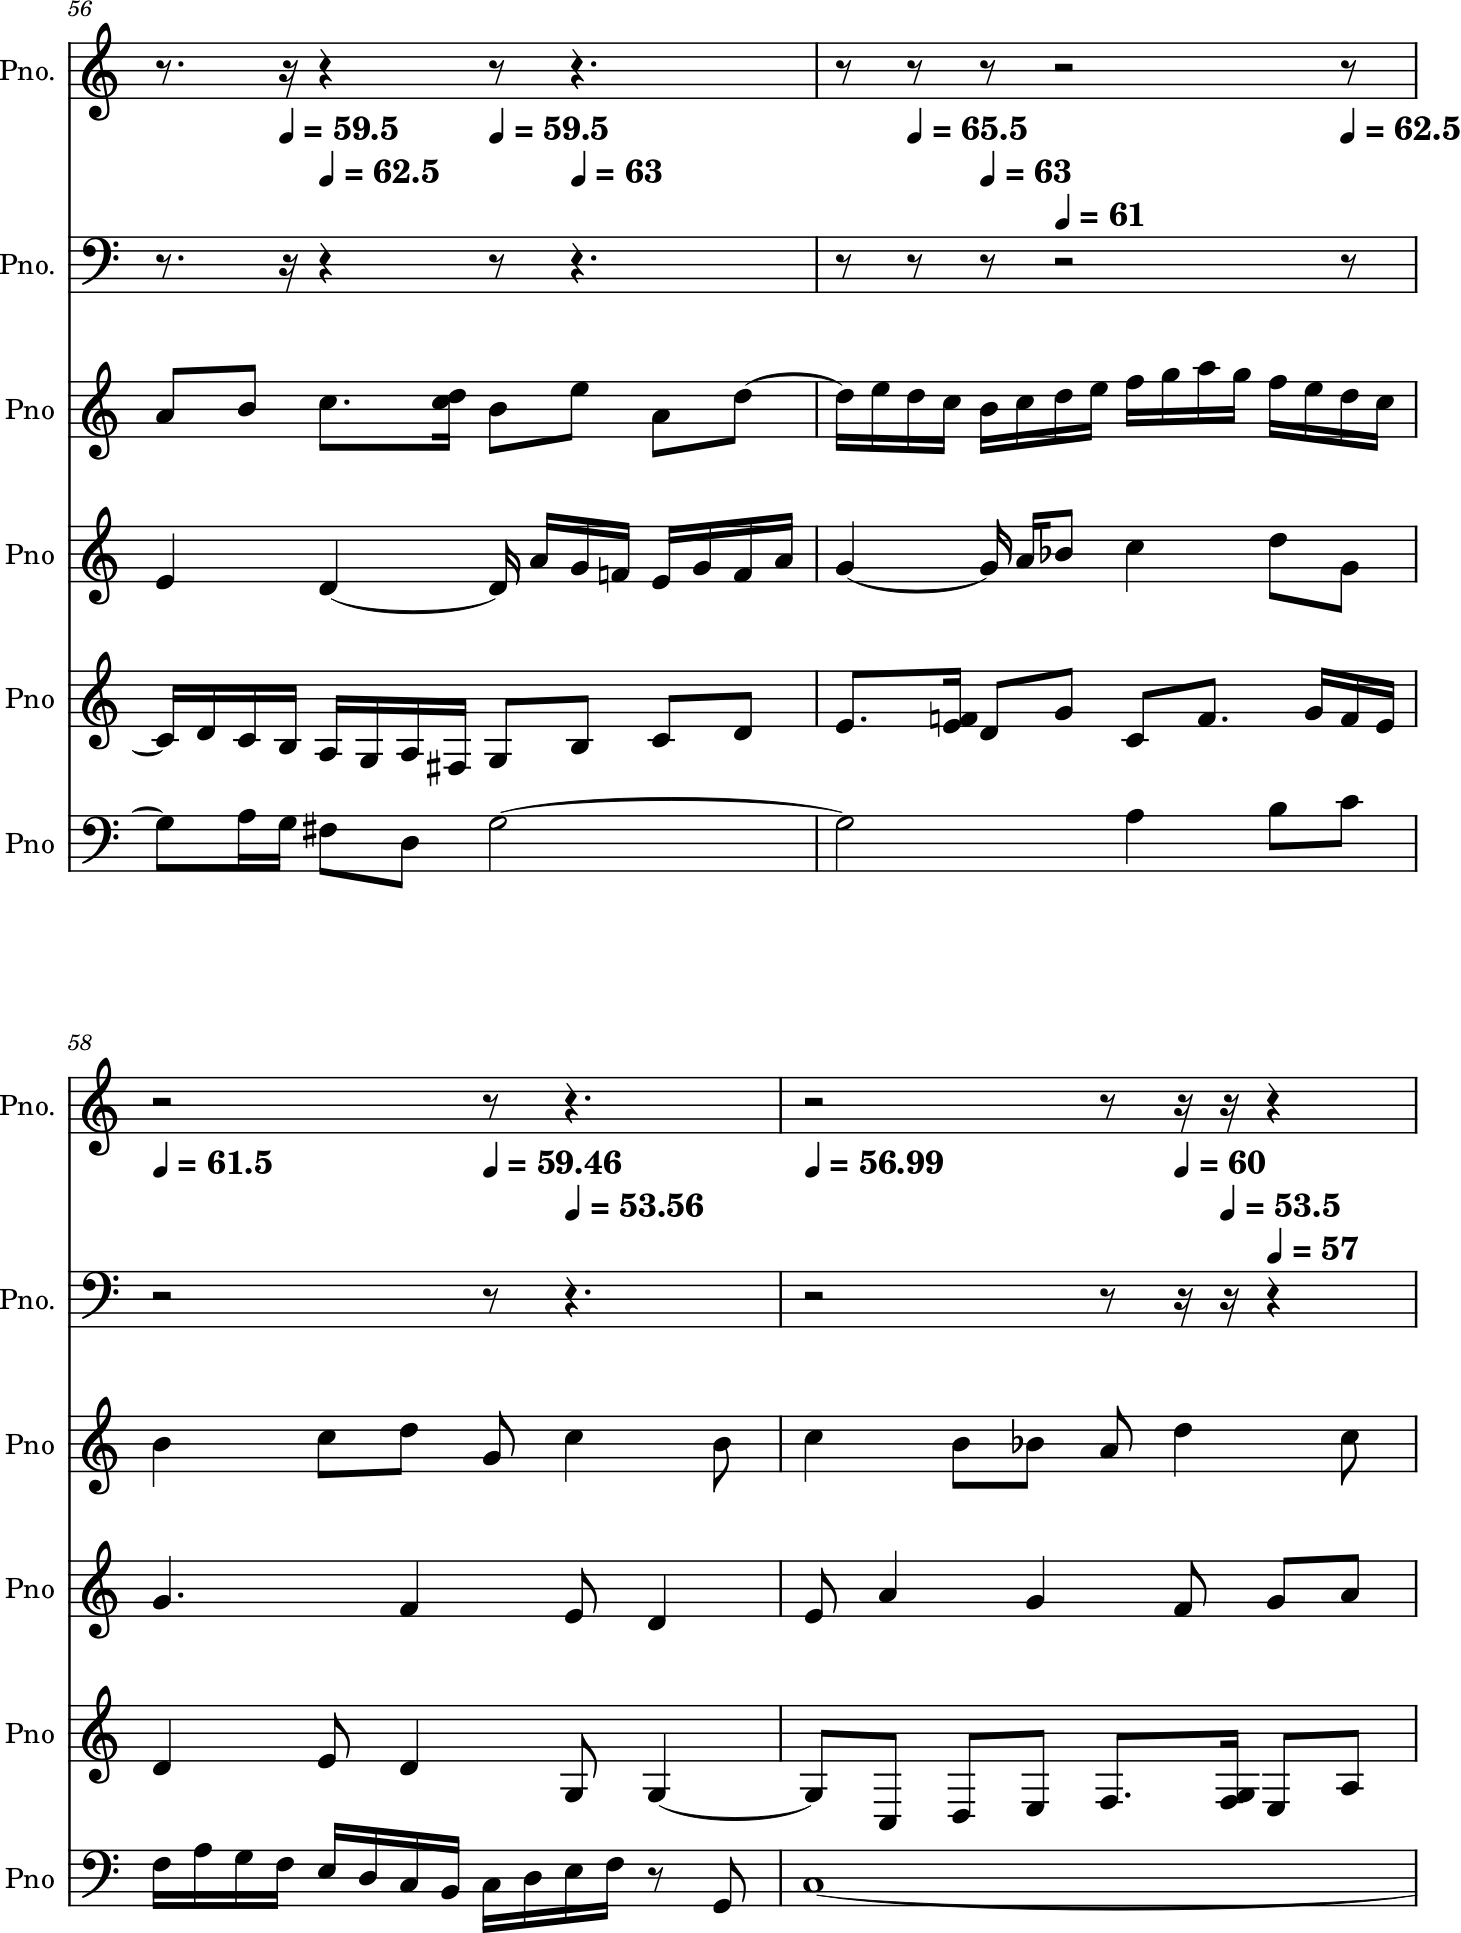

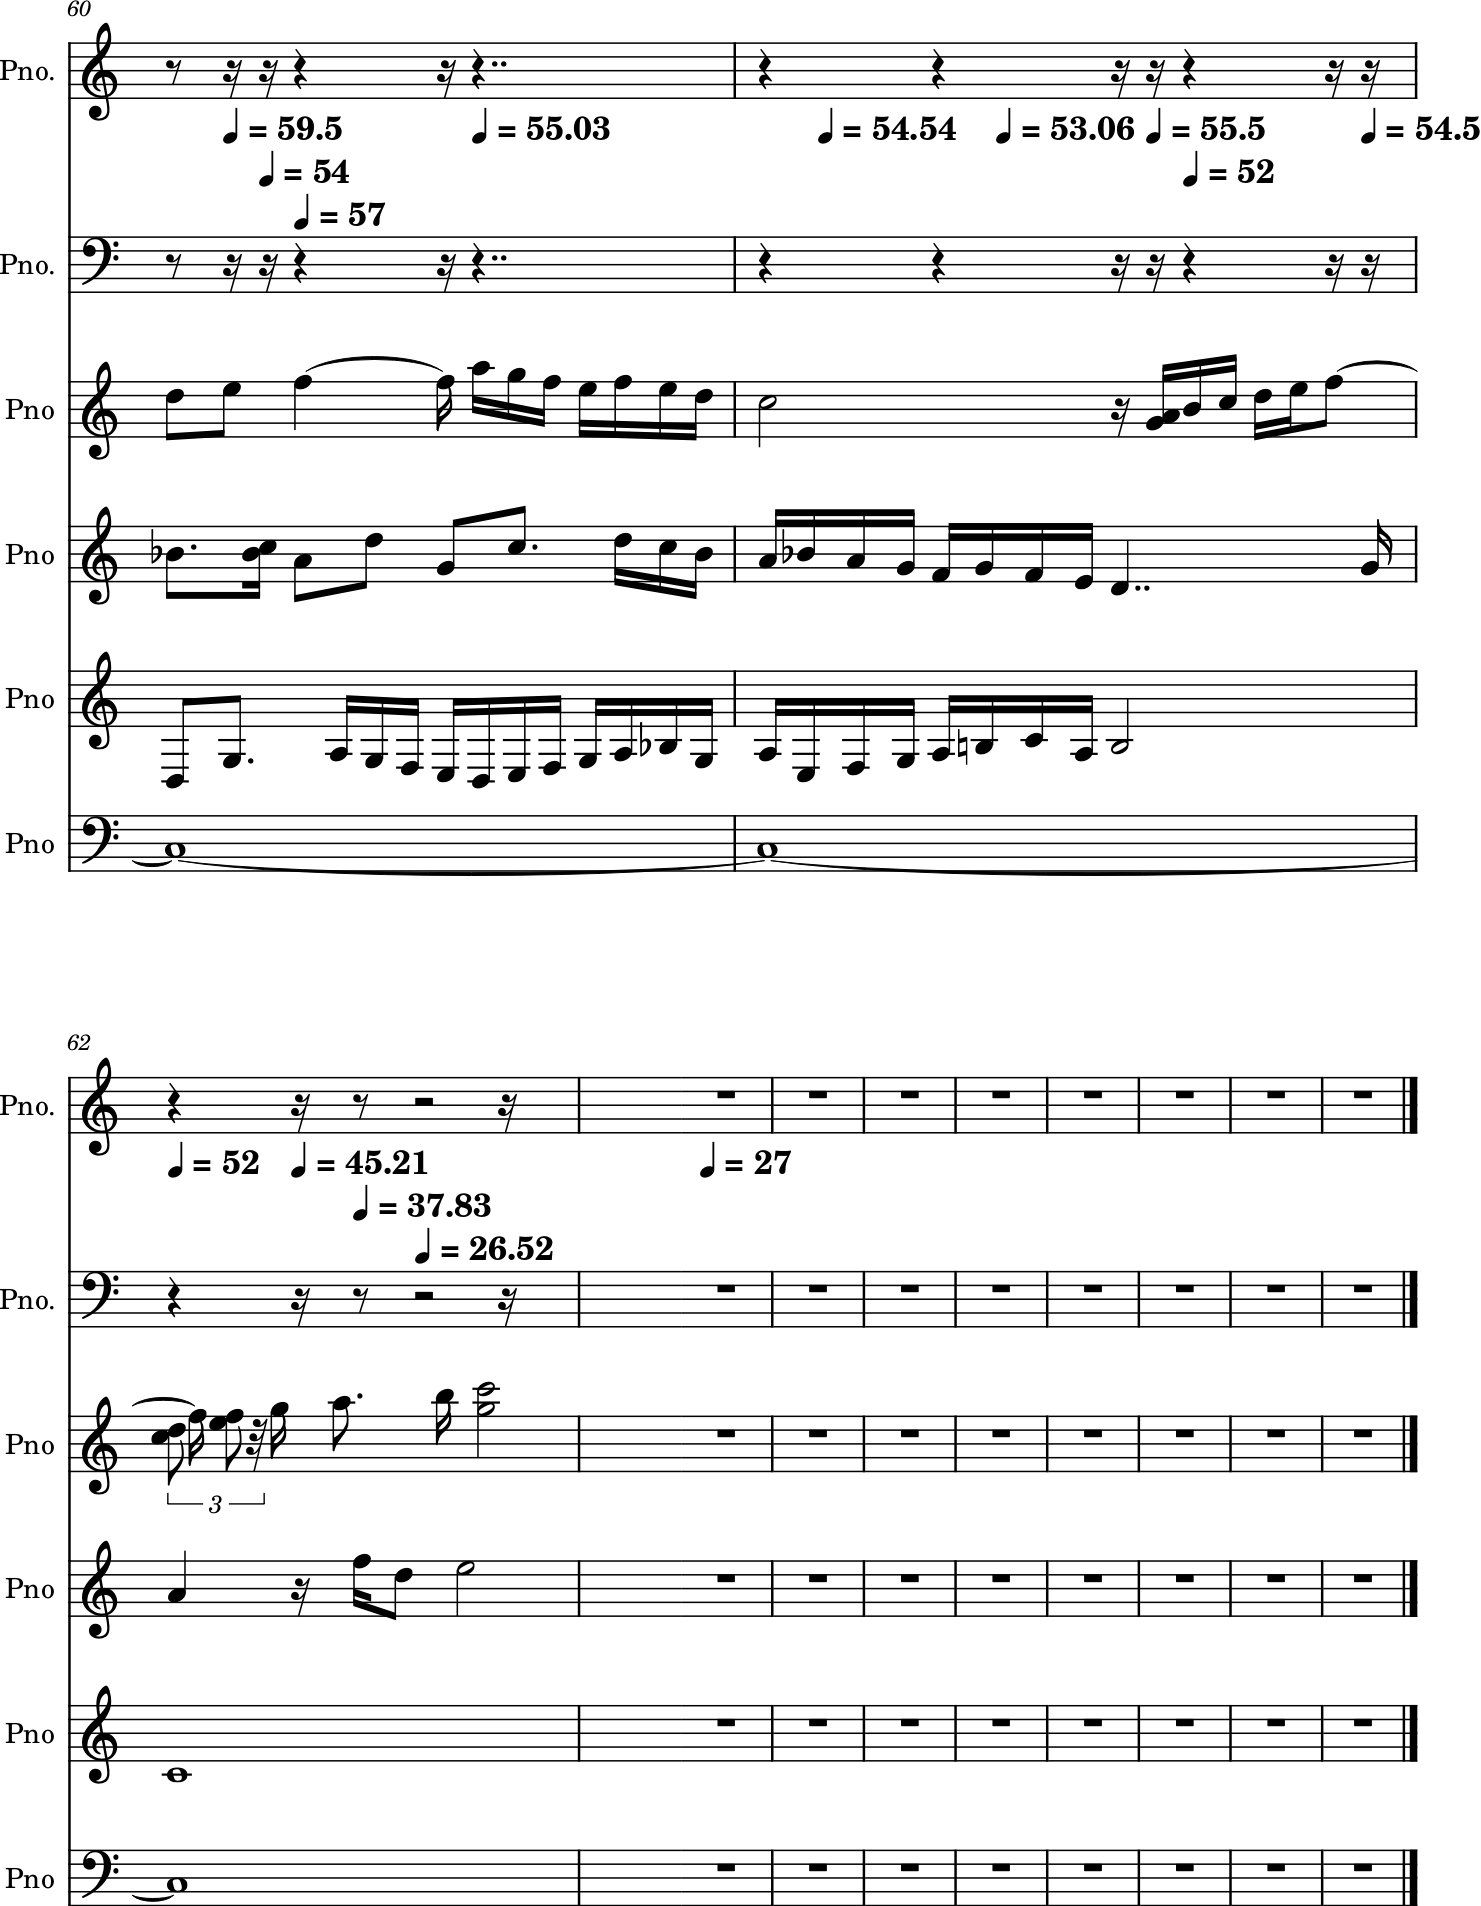

In [73]:
score.show()

In [71]:
score.show('midi')

In [72]:
stream.show('midi')